In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing necessary libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!git clone https://github.com/adavoudi/spdnet

Cloning into 'spdnet'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 191 (delta 0), reused 1 (delta 0), pack-reused 187
Receiving objects: 100% (191/191), 51.49 KiB | 8.58 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [ ]:
from spdnet.spdnet.utils import *
from spdnet.spdnet import StiefelParameter

In [ ]:
%matplotlib inline
import urllib.request
from fastai.basics import *
import sys
import pickle
import tarfile
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from math import *

In [ ]:
# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output
from time import time
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)
import torch
from torch import nn
from torch.optim.optimizer import Optimizer
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
import numpy as np

import random
import scipy.io as spio
from pathlib import Path
from tqdm import tqdm,tqdm_notebook,notebook

In [ ]:
path="/content/drive/MyDrive/shreck2017/HandGestureDataset_SHREC2017/gesture_1/finger_1/subject_1/essai_1/skeletons_world.txt"

In [ ]:
pip install vg

In [ ]:
import vg
#k=vg.normalize(c)

#SPDNet

##Layer SPDNet

In [ ]:
class SPDTransform(nn.Module):

    def __init__(self, input_size, output_size):
        super(SPDTransform, self).__init__()
        self.increase_dim = None
        if output_size > input_size:
            self.increase_dim = SPDIncreaseDim(input_size, output_size)
            input_size = output_size
        self.weight = StiefelParameter(torch.FloatTensor(input_size, output_size), requires_grad=True)
        nn.init.orthogonal_(self.weight)

    def forward(self, input):
        output = input
        if self.increase_dim:
            output = self.increase_dim(output)

        weight = self.weight.unsqueeze(0)
        k=input.size(0)
        weight = weight.expand(k, -1, -1)
        weight=weight.type(torch.DoubleTensor)
        output=output.type(torch.DoubleTensor)
        output = torch.bmm(weight.transpose(1,2), torch.bmm(output, weight))
        return output


class SPDIncreaseDim(nn.Module):

    def __init__(self, input_size, output_size):
        super(SPDIncreaseDim, self).__init__()
        self.register_buffer('eye', torch.eye(output_size, input_size))
        add = np.asarray([0] * input_size + [1] * (output_size-input_size), dtype=np.float32)
        self.register_buffer('add', torch.from_numpy(np.diag(add)))

    def forward(self, input):
        eye = self.eye.unsqueeze(0)
        eye = eye.expand(input.size(0), -1, -1)
        add = self.add.unsqueeze(0)
        add = add.expand(input.size(0), -1, -1)
        input=input.type(torch.DoubleTensor)
        add=add.type(torch.DoubleTensor)
        eye=eye.type(torch.DoubleTensor)
        output = torch.baddbmm(add, eye, torch.bmm(input, eye.transpose(1,2)))
        return output

"""
Yu, K., & Salzmann, M. (2017). Second-order convolutional neural networks. arXiv preprint arXiv:1703.06817.
"""
class ParametricVectorize(nn.Module):

    def __init__(self, input_size, output_size):
        super(ParametricVectorize, self).__init__()
        self.weight = nn.Parameter(torch.ones(output_size, input_size), requires_grad=True)

    def forward(self, input):
        weight = self.weight.unsqueeze(0)
        weight = weight.expand(input.size(0), -1, -1)
        output = torch.bmm(weight, input)
        output = torch.bmm(output, weight.transpose(1,2))
        output = torch.mean(output, 2)
        return output

"""
Huang, Z., & Van Gool, L. J. (2017, February). A Riemannian Network for SPD Matrix Learning. In AAAI (Vol. 1, No. 2, p. 3).
"""
class SPDVectorize(nn.Module):

    def __init__(self, input_size):
        super(SPDVectorize, self).__init__()
        row_idx, col_idx = np.triu_indices(input_size)
        self.register_buffer('row_idx', torch.LongTensor(row_idx))
        self.register_buffer('col_idx', torch.LongTensor(col_idx))

    def forward(self, input):
        s=input.size()
        l=[s,self.row_idx, self.col_idx]
        #withopen("index.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
            #pickle.dump(l, f)
        output = input[:, self.row_idx, self.col_idx]
        return output

class SPDUnVectorizeFunction(Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        n = int(-.5 + 0.5 * np.sqrt(1 + 8 * input.size(1)))
        output = input.new(len(input), n, n)
        output.fill_(0)
        mask_upper = np.triu_indices(n)
        mask_diag = np.diag_indices(n)
        for k, x in enumerate(input):
            output[k][mask_upper] = x
            output[k] = output[k] + output[k].t()   
            output[k][mask_diag] /= 2
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        input = input[0]
        grad_input = None

        if ctx.needs_input_grad[0]:
            n = int(-.5 + 0.5 * np.sqrt(1 + 8 * input.size(1)))
            grad_input = input.new(len(input), input.size(1))
            mask = np.triu_indices(n)
            for k, g in enumerate(grad_output):
                grad_input[k] = g[mask]

        return grad_input


class SPDUnVectorize(nn.Module):

    def __init__(self):
        super(SPDUnVectorize, self).__init__()

    def forward(self, input):
        return SPDUnVectorizeFunction.apply(input)


"""
Huang, Z., & Van Gool, L. J. (2017, February). A Riemannian Network for SPD Matrix Learning. In AAAI (Vol. 1, No. 2, p. 3).
"""
class SPDTangentSpaceFunction(Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        
        output = input.new(input.size(0), input.size(1), input.size(2))
        for k, x in enumerate(input):
            u, s, v = x.svd()
            s.log_()
            output[k] = u.mm(s.diag().mm(u.t()))

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        input = input[0]
        grad_input = None

        if ctx.needs_input_grad[0]:
            eye = input.new(input.size(1))
            eye.fill_(1); eye = eye.diag()
            grad_input = input.new(input.size(0), input.size(1), input.size(1))
            for k, g in enumerate(grad_output):
                x = input[k]
                u, s, v = x.svd()
                
                g = symmetric(g)
                
                s_log_diag = s.log().diag()
                s_inv_diag = (1/s).diag()
                
                dLdV = 2*(g.mm(u.mm(s_log_diag)))
                dLdS = eye * (s_inv_diag.mm(u.t().mm(g.mm(u))))
                
                P = s.unsqueeze(1)
                P = P.expand(-1, P.size(0))
                P = P - P.t()
                mask_zero = torch.abs(P) == 0
                P = 1 / P
                P[mask_zero] = 0
                
                grad_input[k] = u.mm(symmetric(P.t() * (u.t().mm(dLdV)))+dLdS).mm(u.t())


        return grad_input


"""
Huang, Z., & Van Gool, L. J. (2017, February). A Riemannian Network for SPD Matrix Learning. In AAAI (Vol. 1, No. 2, p. 3).
"""
class SPDTangentSpace(nn.Module):

    def __init__(self, input_size, vectorize=True):
        super(SPDTangentSpace, self).__init__()
        self.vectorize = vectorize
        if vectorize:
            self.vec = SPDVectorize(input_size)

    def forward(self, input):
        output = SPDTangentSpaceFunction.apply(input)
        if self.vectorize:
            output = self.vec(output)

        return output


class SPDUnTangentSpaceFunction(Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        
        output = input.new(input.size(0), input.size(1), input.size(2))
        for k, x in enumerate(input):
            u, s, v = x.svd()
            s.exp_()
            output[k] = u.mm(s.diag().mm(u.t()))

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        input = input[0]
        grad_input = None

        if ctx.needs_input_grad[0]:
            eye = input.new(input.size(1))
            eye.fill_(1); eye = eye.diag()
            grad_input = input.new(input.size(0), input.size(1), input.size(1))
            for k, g in enumerate(grad_output):
                x = input[k]
                u, s, v = x.svd()

                g = symmetric(g)
                
                s_exp_diag = s.exp().diag()
                
                dLdV = 2*(g.mm(u.mm(s_exp_diag)))
                dLdS = eye * (s_exp_diag.mm(u.t().mm(g.mm(u))))
                
                P = s.unsqueeze(1)
                P = P.expand(-1, P.size(0))
                P = P - P.t()
                mask_zero = torch.abs(P) == 0
                P = 1 / P
                P[mask_zero] = 0
                
                grad_input[k] = u.mm(symmetric(P.t() * (u.t().mm(dLdV)))+dLdS).mm(u.t())


        return grad_input


class SPDUnTangentSpace(nn.Module):

    def __init__(self, unvectorize=True):
        super(SPDUnTangentSpace, self).__init__()
        self.unvectorize = unvectorize
        if unvectorize:
            self.unvec = SPDUnVectorize()

    def forward(self, input):
        if self.unvectorize:
            input = self.unvec(input)
        output = SPDUnTangentSpaceFunction.apply(input)
        return output


"""
Huang, Z., & Van Gool, L. J. (2017, February). A Riemannian Network for SPD Matrix Learning. In AAAI (Vol. 1, No. 2, p. 3).
"""
class SPDRectifiedFunction(Function):

    @staticmethod
    def forward(ctx, input, epsilon):
        ctx.save_for_backward(input, epsilon)

        output = input.new(input.size(0), input.size(1), input.size(2))
        for k, x in enumerate(input):
            u, s, v = x.svd()
            u=u.type(torch.DoubleTensor)
            v=v.type(torch.DoubleTensor)
            s=s.type(torch.DoubleTensor)
            output=output.type(torch.DoubleTensor)
            epsilon=epsilon.type(torch.DoubleTensor)
            s[s < epsilon[0]] = epsilon[0]
            output[k] = u.mm(s.diag().mm(u.t()))
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, epsilon = ctx.saved_tensors
        grad_input = None
        
        if ctx.needs_input_grad[0]:
            eye = input.new(input.size(1))
            eye.fill_(1); eye = eye.diag()
            grad_input = input.new(input.size(0), input.size(1), input.size(2))
            for k, g in enumerate(grad_output):
                if len(g.shape) == 1:
                    continue

                g = symmetric(g)

                x = input[k]
                u, s, v = x.svd()
                s=s.float()
                max_mask = s > epsilon
                u=u.type(torch.DoubleTensor)
                v=v.type(torch.DoubleTensor)
                s_max_diag = s.clone(); s_max_diag[~max_mask] = epsilon; s_max_diag = s_max_diag.diag()
                s_max_diag=s_max_diag.type(torch.DoubleTensor)
                Q = max_mask.float().diag()
                
                dLdV = 2*(g.mm(u.mm(s_max_diag)))
                g=g.type(torch.DoubleTensor)
                Q=Q.type(torch.DoubleTensor)
                dLdS = eye * (Q.mm(u.t().mm(g.mm(u))))
                
                P = s.unsqueeze(1)
                P = P.expand(-1, P.size(0))
                P = P - P.t()
                mask_zero = torch.abs(P) == 0
                P = 1 / P
                P[mask_zero] = 0

                grad_input[k] = u.mm(symmetric(P.t() * u.t().mm(dLdV))+dLdS).mm(u.t())
            
        return grad_input, None


"""
Huang, Z., & Van Gool, L. J. (2017, February). A Riemannian Network for SPD Matrix Learning. In AAAI (Vol. 1, No. 2, p. 3).
"""
class SPDRectified(nn.Module):

    def __init__(self, epsilon=1e-4):
        super(SPDRectified, self).__init__()
        self.register_buffer('epsilon', torch.FloatTensor([epsilon]))

    def forward(self, input):
        output = SPDRectifiedFunction.apply(input, self.epsilon)
        return output


class SPDPowerFunction(Function):

    @staticmethod
    def forward(ctx, input, weight):
        ctx.save_for_backward(input, weight)

        output = input.new(input.size(0), input.size(1), input.size(2))
        for k, x in enumerate(input):
            u, s, v = x.svd()
            s = torch.exp(weight * torch.log(s))
            output[k] = u.mm(s.diag().mm(u.t()))
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        grad_input = None
        grad_weight = None

        eye = input.new(input.size(1))
        eye.fill_(1); eye = eye.diag()
        grad_input = input.new(input.size(0), input.size(1), input.size(2))
        grad_weight = weight.new(input.size(0), weight.size(0))
        for k, g in enumerate(grad_output):
            if len(g.shape) == 1:
                continue

            x = input[k]
            u, s, v = x.svd() 

            g = symmetric(g)
            
            s_log = torch.log(s)
            s_power = torch.exp(weight * s_log)

            s_power = s_power.diag()
            s_power_w_1 = weight * torch.exp((weight-1) * s_log)
            s_power_w_1 = s_power_w_1.diag()
            s_log = s_log.diag()
            
            grad_w = s_log.mm(u.t().mm(s_power.mm(u))).mm(g)
            grad_weight[k] = grad_w.diag()

            dLdV = 2*(g.mm(u.mm(s_power)))
            dLdS = eye * (s_power_w_1.mm(u.t().mm(g.mm(u))))
            
            P = s.unsqueeze(1)
            P = P.expand(-1, P.size(0))
            P = P - P.t()
            mask_zero = torch.abs(P) == 0
            P = 1 / P
            P[mask_zero] = 0            
            
            grad_input[k] = u.mm(symmetric(P.t() * u.t().mm(dLdV))+dLdS).mm(u.t())
                
        grad_weight = grad_weight.mean(0)
        
        return grad_input, grad_weight


class SPDPower(nn.Module):

    def __init__(self, input_dim):
        super(SPDPower, self).__init__()
        self.weight = nn.Parameter(torch.ones(input_dim), requires_grad=True)
        # nn.init.normal(self.weight)

    def forward(self, input):
        output = SPDPowerFunction.apply(input, self.weight)
        return output


##utils

In [ ]:
def is_pos_def(A):
  AA= A.cpu().detach().numpy()
  return torch.equal(A, A.T) & np.all(np.linalg.eigvals(AA) > 0)

In [ ]:
def symmetric(A):
    return 0.5 * (A + A.t())

In [ ]:
def is_nan_or_inf(A):
    C1 = torch.nonzero(A == float('inf'))
    C2 = torch.nonzero(A != A)
    if len(C1.size()) > 0 or len(C2.size()) > 0:
        return True
    return False

In [ ]:
def matrix_operator(A, operator):
    u, s, v = A.svd()
    if operator == 'sqrtm':
        s.sqrt_()
    elif operator == 'rsqrtm':
        s.rsqrt_()
    elif operator == 'logm':
        s.log_()
    elif operator == 'expm':
        s.exp_()
    else:
        raise('operator %s is not implemented' % operator)
    
    output = u.mm(s.diag().mm(u.t()))
    return output

In [ ]:
def tangent_space(A, ref, inverse_transform=False):
    ref_sqrt = matrix_operator(ref, 'sqrtm')
    ref_sqrt_inv = matrix_operator(ref, 'rsqrtm')
    middle = ref_sqrt_inv.mm(A.mm(ref_sqrt_inv))
    if inverse_transform:
        middle = matrix_operator(middle, 'logm')
    else:
        middle = matrix_operator(middle, 'expm')
    out = ref_sqrt.mm(middle.mm(ref_sqrt))
    return out

In [ ]:
def untangent_space(A, ref):
    return tangent_space(A, ref, True)

In [ ]:
def parallel_transform(A, ref1, ref2):
    print(A.size(), ref1.size(), ref2.size())
    out = untangent_space(A, ref1)
    out = tangent_space(out, ref2)
    return out

In [ ]:
def orthogonal_projection(A, B):
    #out = A - B.mm(symmetric(B.transpose(0,1).mm(A)))
    out = A - A @ B.transpose(-1,-2) @ B
    return out

In [ ]:
def retraction(A, ref):
    data = A + ref
    Q, R = data.qr()
    # To avoid (any possible) negative values in the output matrix, we multiply the negative values by -1
    sign = (R.triu().tril().sign() + 0.5).sign().triu().tril()
    out = Q @ sign
    return out


In [ ]:
d=torch.randn(5)
(d.sign()+0.5).sign()

tensor([ 1., -1.,  1., -1.,  1.])

#ST-TS-HGR-NET Architecture 2


In [ ]:
def sym(A):
  return 0.5*(A+A.transpose(-1,-2))

##Convolution Layer

In [ ]:
def neighbor(n):
  N=[n]
  h=[n+4,n+5,n+1,n-3,n-4,n-5,n-1,n+3]
  for i in h:
    if i<20 and i>=0:
      N.append(i)
  return N

In [ ]:
class convolution(nn.Module):
  def __init__(self):
    super(convolution,self).__init__()
    self.weight = nn.Parameter(FloatTensor(9,9,3), requires_grad=True)
    nn.init.orthogonal_(self.weight)
  def forward(self,inputs):
    l={0:1,4:2,5:3,1:4,-3:5,-4:6,-5:7,-1:8,3:9}
    p=torch.zeros(tuple((list(inputs.size()[:-2])+[9,1])))
    for i in range(20):
      p[:,:,i]=sum([self.weight[l[j-i]-1].type(torch.DoubleTensor) @ inputs[:,:,i].type(torch.DoubleTensor)  for j in neighbor(i)])
    return p

##Before ST-TS

In [ ]:
J={i:[4*i,1+4*i,2+4*i,3+4*i] for i in range(5)}
J

{0: [0, 1, 2, 3],
 1: [4, 5, 6, 7],
 2: [8, 9, 10, 11],
 3: [12, 13, 14, 15],
 4: [16, 17, 18, 19]}

In [ ]:
def sequence(t):
  d=dict()
  d[0]=range(t)
  d[1]=range(int(t/2))
  d[2]=range(int(t/2),t)
  d[3]=range(int(t/3))
  d[4]=range(int(t/3),2*int(t/3))
  d[5]=range(2*int(t/3),t)
  return d

##ST-GA-NET

###First Gauss Aggregation Layer

In [ ]:
class Gauss_agg1_st_function(Function):
  @staticmethod
  def forward(ctx,input,t0):
    
    t0=torch.tensor(t0)
    ctx.save_for_backward(input,t0)
    batch,nb_frames,joints,coor,col=input.size()
    #ST
    output_st=[]
    for s in range(6):
      binf,bsup=min(sequence(nb_frames)[s]),max(sequence(nb_frames)[s])
      x=input[:,binf:bsup+1].clone().transpose(1,2).reshape(batch,5,4,bsup-binf+1,coor,col)
      y=x.clone()
      x[:,:,1:-1]=(x[:,:,1:-1]+x[:,:,:-2]+x[:,:,2:])/3
      mu=x.mean(2)
      cov=torch.zeros(batch,5,bsup-binf+1,coor,coor)
      m=mu.unsqueeze(2).expand(x.size())
      xm,x0,xp=y[:,:,:,:-2]-m[:,:,:,1:-1], y-m, y[:,:,:,2:]-m[:,:,:,1:-1]
      cov[:,:,1:-1]=((xm @ xm.transpose(-1,-2) +x0[:,:,:,1:-1] @ x0[:,:,:,1:-1].transpose(-1,-2) + xp @ xp.transpose(-1,-2))/3).mean(2)
      cov[:,:,::bsup-binf]=(x0[:,:,:,::bsup-binf] @ x0[:,:,:,::bsup-binf].transpose(-1,-2)).mean(2)
  
      elt00 = cov + mu @ mu.transpose(-1,-2)
      elt01 = mu
      elt10 = mu.transpose(-1,-2)
      elt11 = torch.ones(batch,5,bsup-binf+1,1,1)
      output_st.append(torch.cat((torch.cat((elt00,elt01),-1),torch.cat((elt10,elt11),-1)),-2))
    return torch.cat(tuple(output_st),2)


  @staticmethod
  def backward(ctx,grad_output_st):
    
    input,t0 = ctx.saved_tensors
    t0=int(t0)
    batch,nb_frames,joints,coor,col=input.size()
    grad_input_st=torch.zeros(input.size())
    grad_output_st=grad_output_st.split([len(sequence(nb_frames)[s]) for s in range(6)],2)
    input=input.reshape(batch,nb_frames,joints,coor)
    for s in range(6):
      g=sym(grad_output_st[s]).transpose(1,2)
      binf,bsup=min(sequence(nb_frames)[s]),max(sequence(nb_frames)[s])
      X=input[:,binf:bsup+1].clone().reshape(batch,bsup-binf+1,5,4,coor)
      #outside the edges of frames
      Xs=torch.cat((X[:,1:-1],X[:,:-2],X[:,2:]),-2)
      B=torch.eye(coor+1,coor).reshape(1,1,1,coor+1,coor).expand(batch,bsup-binf-1,5,coor+1,coor)
      b=torch.cat((torch.zeros(coor),torch.ones(1))).reshape(1,1,1,coor+1,1).expand(batch,bsup-binf-1,5,coor+1,1)
      vect_one=torch.ones(batch,bsup-binf-1,5,12,1)
      x=(1/6)*(Xs @ B.transpose(-1,-2) + vect_one @ b.transpose(-1,-2) ) @ g[:,1:-1] @ B
      grad_input_st[:,binf+1:bsup]+=((x[:,:,:,:4]+x[:,:,:,4:8]+x[:,:,:,8:12])/3).reshape(batch,bsup-binf-1,20,coor).unsqueeze(-1)
      #The edges of frames
      Xs=X[:,::bsup-binf].reshape(batch,2,5,4,coor)
      B=torch.eye(coor+1,coor).reshape(1,1,1,coor+1,coor).expand(batch,2,5,coor+1,coor)
      b=torch.cat((torch.zeros(coor),torch.ones(1))).reshape(1,1,1,coor+1,1).expand(batch,2,5,coor+1,1)
      vect_one=torch.ones(batch,2,5,4,1)
      x=(1/2)*(Xs @ B.transpose(-1,-2) + vect_one @ b.transpose(-1,-2) ) @ g[:,::bsup-binf] @ B
      grad_input_st[:,binf:bsup+1:bsup-binf]+=x.reshape(batch,2,20,coor).unsqueeze(-1)    
    return grad_input_st/3,None

In [ ]:
class Gauss_agg1_st(nn.Module):
  def __init__(self,t0=1):
    super(Gauss_agg1_st,self).__init__()
    self.t0=t0
  def forward(self,input):
    return Gauss_agg1_st_function.apply(input,self.t0)

###ReEig Layer

In [ ]:
class ReEig_st_function(Function):
  @staticmethod
  def forward(ctx,input_st,eps):
    eps=torch.tensor(eps)
    #ST
    u,S,v=input_st.svd()
    ctx.save_for_backward(u,S.clone(),eps)
    S[S<eps]=eps
    return u @ S.diag_embed() @ u.transpose(-1,-2),u,S
  
  @staticmethod
  def backward(ctx,grad_output_st,grad_u,grad_S):
    u,S,eps = ctx.saved_tensors
    eps=float(eps)
    #ST
    P = S.unsqueeze(-1).expand(u.size())
    P = P - P.transpose(-1,-2)
    mask_zero = torch.abs(P) == 0
    P = 2 / P
    P[mask_zero] = 0
    Q=torch.ones(S.size())
    Q[S<eps]=0
    Q=Q.diag_embed()
    g=sym(grad_output_st)
    S[S<eps]=eps
    dLdu= 2* g @ u @ S.diag_embed()
    dLdS= Q @ u.transpose(-1,-2) @ g @ u
    idx=torch.arange(0,dLdS.size(3), out=torch.LongTensor())
    k=dLdS[:,:,:,idx,idx].diag_embed()
    grad_input_st=u @ (( P.transpose(-1,-2)*(u.transpose(-1,-2) @ sym(dLdu))) + k) @ u.transpose(-1,-2)
    return grad_input_st,None

In [ ]:
class ReEig_st(nn.Module):
  def __init__(self,eps=10**(-4)):
    super(ReEig_st,self).__init__()
    self.eps=eps

  def forward(self,input_st):
    return ReEig_st_function.apply(input_st,self.eps)

###LogEig Layer

In [ ]:
class LogEig_st_function(Function):
  @staticmethod
  def forward(ctx,input_st,u,S):
    #ST
    s=S[:,:,:,:,0].log().diag_embed()
    ctx.save_for_backward(u,S,s)
    return u @ s @ u.transpose(-1,-2)
    
  @staticmethod
  def backward(ctx,grad_output_st):
    u,S,s = ctx.saved_tensors
    g=sym(grad_output_st)
    P=S.clone()
    P = P - P.transpose(-1,-2)
    mask_zero = torch.abs(P) == 0
    P = 2 / P
    P[mask_zero] = 0
    dLdu= 2* g @ u @ s
    dLdS= (1/S[:,:,:,:,0]).diag_embed() @ u.transpose(-1,-2) @ g @ u
    idx=torch.arange(0,dLdS.size(3), out=torch.LongTensor())
    k=dLdS[:,:,:,idx,idx].diag_embed()
    grad_input_st=u @(( P.transpose(-1,-2)*(u.transpose(-1,-2) @ sym(dLdu))) + k) @ u.transpose(-1,-2)
    
    return grad_input_st,dLdu,dLdS

In [ ]:
class LogEig_st(nn.Module):
  def __init__(self):
    super(LogEig_st,self).__init__()

  def forward(self,input_st,u,S):
    return LogEig_st_function.apply(input_st,u,S.unsqueeze(-1).expand(u.size()))

###VecMat Layer

In [ ]:
class VecMat_st_function(Function):

  @staticmethod
  def forward(ctx,input_st):
    ctx.save_for_backward(input_st)
    #ST
    batch,fingers,nb_frames,row,col=input_st.size()
    input_st.abs_()
    input_st+=(sqrt(2)-1)*input_st.triu(1)
    id=torch.LongTensor([[i,j] for i in range(row) for j in range(i,row)]).T
    output_st=input_st[:,:,:,id[0],id[1]].unsqueeze(-1)
    return output_st

  @staticmethod
  def backward(ctx,grad_output_st):
    input_st=ctx.saved_tensors
    input_st=input_st[0]
    #ST
    batch,fingers,nb_frames,row,col=input_st.size()
    g=torch.zeros(batch,fingers,nb_frames,row,col)
    j=0
    for i in range(row):
      g[:,:,:,i,i:]=grad_output_st[:,:,:,j:j+row-i,0]
      g[:,:,:,i:,i]=g[:,:,:,i,i:]
      j+=row-i
    g+=(sqrt(2)-1)*(g.triu(1)+g.tril(-1))
    return g

In [ ]:
class VecMat_st(nn.Module):
  def __init__(self):
    super(VecMat_st,self).__init__()

  def forward(self,input_st):
    return VecMat_st_function.apply(input_st)

###Second Gauss aggregation Layer

In [ ]:
class Gauss_agg2_st_function(Function):
  @staticmethod
  def forward(ctx,x0,x1,x2,x3,x4,x5):
    ctx.save_for_backward(x0,x1,x2,x3,x4,x5)
    input_st=[x0,x1,x2,x3,x4,x5]
    #ST
    mu=torch.zeros(x0.size(0),6,x0.size(1),x0.size(3),1)
    cov=torch.zeros(x0.size(0),6,x0.size(1),x0.size(3),x0.size(3))
    for s in range(6):
      batch,fingers,nb_frames,row,col=input_st[s].size()
      mu[:,s]=input_st[s].mean(2)
      x=input_st[s]-mu[:,s].unsqueeze(2).expand(batch,fingers,nb_frames,row,col)
      cov[:,s]=(x @ x.transpose(-1,-2)).mean(2)
    elt00 = cov + mu @ mu.transpose(-1,-2)
    elt01 = mu
    elt10 = mu.transpose(-1,-2)
    elt11 = torch.ones(batch,6,5,1,1)
    return torch.cat((torch.cat((elt00,elt01),-1),torch.cat((elt10,elt11),-1)),-2)
  @staticmethod
  def backward(ctx,grad_output_st):
    x0,x1,x2,x3,x4,x5=ctx.saved_tensors
    input_st=[x0,x1,x2,x3,x4,x5]
    grad_input_st=[]
    batch,fingers,nb_frames,row,col=x0.size()
    B=torch.eye(row+1,row).reshape(1,1,row+1,row).expand(batch,fingers,row+1,row)
    b=torch.cat((torch.zeros(row),torch.ones(1))).reshape(1,1,1,row+1).expand(batch,fingers,1,row+1)
    g=sym(grad_output_st)
    #ST
    for s in range(6):
      nb_frames=input_st[s].size(2)
      x=input_st[s].squeeze(-1)
      vect_one=torch.ones(batch,fingers,nb_frames,1)
      gr=(2/(nb_frames))* (x @ B.transpose(-1,-2) + vect_one @ b) @ g[:,s] @ B
      grad_input_st.append(gr.unsqueeze(-1))
    return grad_input_st[0],grad_input_st[1],grad_input_st[2],grad_input_st[3],grad_input_st[4],grad_input_st[5]

In [ ]:
class Gauss_agg2_st(nn.Module):
  def __init__(self):
    super(Gauss_agg2_st,self).__init__()

  def forward(self,input_st):
    nb_frames=int(input_st.size(2)/3)
    l_sp=[len(sequence(nb_frames)[s]) for s in range(6)]
    x0,x1,x2,x3,x4,x5=input_st.split(l_sp,2)
    return Gauss_agg2_st_function.apply(x0,x1,x2,x3,x4,x5)

##TS-GA-NET

###First Gauss Aggregation Layer

In [ ]:
class Gauss_agg1_ts_function(Function):
  @staticmethod
  def forward(ctx,input_ts,NS):
    NS=torch.tensor(NS)
    ctx.save_for_backward(input_ts,NS)
    batch,nb_frames,joints,coordinates,col=input_ts.size()
    #TRY TS
    inputs=input_ts.reshape(batch,nb_frames,5,4,coordinates,col)
    mu=torch.zeros((batch,6,5,NS,4,coordinates,1))
    cov=torch.zeros((batch,6,5,NS,4,coordinates,coordinates))
    for s in range(6):
      binf,bsup=min(sequence(nb_frames)[s]),max(sequence(nb_frames)[s])
      nb_fr=int((bsup-binf+1)/NS)
      for k in range(NS-1):
        mu[:,s,:,k]=inputs[:,k*nb_fr:(k+1)*nb_fr].mean(1)
        x=inputs[:,k*nb_fr:(k+1)*nb_fr]-mu[:,s,:,k].unsqueeze(1).expand(batch,nb_fr,5,4,coordinates,1)
        cov[:,s,:,k]=(x @ x.transpose(-1,-2)).mean(1)
      k=NS-1
      mu[:,s,:,k]=inputs[:,k*nb_fr:].mean(1)
      x=inputs[:,k*nb_fr:nb_frames]-mu[:,s,:,k].unsqueeze(1).expand(inputs[:,k*nb_fr:nb_frames].size())
      cov[:,s,:,k]=(x @ x.transpose(-1,-2)).mean(1)
    elt00 = cov + mu @ mu.transpose(-1,-2)
    elt01 = mu
    elt10 = mu.transpose(-1,-2)
    elt11 = torch.ones(batch,6,5,NS,4,1,1)
    return torch.cat((torch.cat((elt00,elt01),-1),torch.cat((elt10,elt11),-1)),-2)

  @staticmethod
  def backward(ctx,grad_output_ts):
    input_ts,NS = ctx.saved_tensors
    NS=int(NS)
    batch,nb_frames,joints,row,col=input_ts.size()
    grad_input_ts=torch.zeros(input_ts.size())
    inputs=input_ts.transpose(1,2).squeeze().reshape(batch,5,4,nb_frames,row).type(torch.DoubleTensor)
    #TS
    g=sym(grad_output_ts).type(torch.DoubleTensor)
    B=torch.eye(row+1,row).reshape(1,1,1,row+1,row).expand(batch,5,4,row+1,row).type(torch.DoubleTensor)
    b=torch.cat((torch.zeros(row),torch.ones(1))).reshape(1,1,1,1,row+1).expand(batch,5,4,1,row+1)
    for s in range(6):
      binf,bsup=min(sequence(nb_frames)[s]),max(sequence(nb_frames)[s])
      nb_fr=int((bsup-binf+1)/NS)
      vect_one=torch.ones(batch,5,4,nb_fr,1)
      for k in range(NS-1):
        x = (2/nb_fr)* (inputs[:,:,:,k*nb_fr:(k+1)*nb_fr] @ B.transpose(-1,-2) + vect_one @ b) @ g[:,s,:,k] @ B
        grad_input_ts[:,k*nb_fr:(k+1)*nb_fr]+=x.reshape(batch,20,nb_fr,row,col).transpose(1,2)
      k=NS-1
      rest_fr=inputs[0,0,0,k*nb_fr:].size(0)
      vect_one=torch.ones(batch,5,4,rest_fr,1)
      x = (2/nb_fr)* (inputs[:,:,:,k*nb_fr:] @ B.transpose(-1,-2) + vect_one @ b) @ g[:,s,:,k] @ B
      grad_input_ts[:,k*nb_fr:]+=x.reshape(batch,20,rest_fr,row,col).transpose(1,2)
    return grad_input_ts/3,None

In [ ]:
class Gauss_agg1_ts(nn.Module):
  def __init__(self,NS=15):
    super(Gauss_agg1_ts,self).__init__()
    self.NS=NS
  def forward(self,input):
    return Gauss_agg1_ts_function.apply(input,self.NS)

###ReEig Layer

In [ ]:
class ReEig_ts_function(Function):
  @staticmethod
  def forward(ctx,input_ts,eps):
    eps=torch.tensor(eps)
    #TS
    u,S,v=input_ts.svd()
    ctx.save_for_backward(u,S.clone(),eps)
    S[S<eps]=eps
    return u @ S.diag_embed() @ u.transpose(-1,-2),u,S 
  
  @staticmethod
  def backward(ctx,grad_output_ts,grad_u,grad_S):
    u,S,eps= ctx.saved_tensors
    #TS
    P = S.unsqueeze(-1).expand(u.size())
    P = P - P.transpose(-1,-2)
    mask_zero = torch.abs(P) == 0
    P = 2 / P
    P[mask_zero] = 0
    Q=torch.ones(S.size())
    Q[S<eps]=0
    Q=Q.diag_embed()
    g=sym(grad_output_ts) 
    S[S<eps]=eps
    dLdu= 2* g @ u @ S.diag_embed()
    dLdS= Q @ u.transpose(-1,-2) @ g @ u
    idx=torch.arange(0,dLdS.size(-1), out=torch.LongTensor())
    k=dLdS[:,:,:,:,:,idx,idx].diag_embed()
    grad_input_ts=u @ (( P.transpose(-1,-2)*(u.transpose(-1,-2) @ sym(dLdu))) + k) @ u.transpose(-1,-2)
    return grad_input_ts,None

In [ ]:
class ReEig_ts(nn.Module):
  def __init__(self,eps=10**(-4)):
    super(ReEig_ts,self).__init__()
    self.eps=eps

  def forward(self,input_ts):
    return ReEig_ts_function.apply(input_ts,self.eps)

###LogEig Layer

In [ ]:
class LogEig_ts_function(Function):
  @staticmethod
  def forward(ctx,input_ts,u,S):
    s=S[:,:,:,:,:,:,0].log().diag_embed()
    ctx.save_for_backward(u,S,s)
    return u @ s @ u.transpose(-1,-2) 
    
  @staticmethod
  def backward(ctx,grad_output_ts):
    u,S,s = ctx.saved_tensors
    g=sym(grad_output_ts)
    S[S<0.0001]=0.0001
    P=S.clone()
    P = P - P.transpose(-1,-2)
    mask_zero = torch.abs(P) == 0
    P = 2 / P
    P[mask_zero] = 0
    dLdu= 2* g @ u @ s
    dLdS= (1/S[:,:,:,:,:,:,0]).diag_embed() @ u.transpose(-1,-2) @ g @ u
    idx=torch.arange(0,dLdS.size(-1), out=torch.LongTensor())
    k=dLdS[:,:,:,:,:,idx,idx].diag_embed()
    grad_input_ts=u @(( P.transpose(-1,-2)*(u.transpose(-1,-2) @ sym(dLdu))) + k) @ u.transpose(-1,-2)
    return grad_input_ts,dLdu,dLdS

In [ ]:
class LogEig_ts(nn.Module):
  def __init__(self):
    super(LogEig_ts,self).__init__()

  def forward(self,input_ts,u,S):
    return LogEig_ts_function.apply(input_ts,u,S.unsqueeze(-1).expand(u.size()))

###VecMat Layer

In [ ]:
class VecMat_ts_function(Function):

  @staticmethod
  def forward(ctx,input_ts):
    ctx.save_for_backward(input_ts)
    #TS
    row=input_ts.size(-1)
    input_ts.abs_()
    input_ts+=(sqrt(2)-1)*input_ts.triu(1)
    id=torch.LongTensor([[i,j] for i in range(row) for j in range(i,row)]).T
    output_ts=input_ts[:,:,:,:,:,id[0],id[1]].unsqueeze(-1)
    return output_ts

  @staticmethod
  def backward(ctx,grad_output_ts):
    input_ts=ctx.saved_tensors
    input_ts=input_ts[0]
    #TS
    batch,seq,fingers,NS,joints,row,col=input_ts.size()
    grad_input_ts=torch.zeros(input_ts.size())
    j=0
    for i in range(row):
      grad_input_ts[:,:,:,:,:,i,i:]=grad_output_ts[:,:,:,:,:,j:j+row-i,0]
      grad_input_ts[:,:,:,:,:,i:,i]=grad_input_ts[:,:,:,:,:,i,i:]
      j+=row-i
    grad_input_ts+=(sqrt(2)-1)*(grad_input_ts.triu(1)+grad_input_ts.tril(-1))
    return grad_input_ts

In [ ]:
class VecMat_ts(nn.Module):
  def __init__(self):
    super(VecMat_ts,self).__init__()

  def forward(self,input_ts):
    return VecMat_ts_function.apply(input_ts)

###Second Gauss aggregation Layer

In [ ]:
class Gauss_agg2_ts_function(Function):
  @staticmethod
  def forward(ctx,input_ts):
    ctx.save_for_backward(input_ts)
    #TS
    batch,seq,fingers,NS,joints,row,col=input_ts.size()
    input_ts=input_ts.reshape(batch,seq,fingers,NS*joints,row,col)
    mu=input_ts.mean(3)
    x=input_ts-mu.unsqueeze(3).expand(input_ts.size())
    cov=(x @ x.transpose(-1,-2)).mean(3)
    elt00 = cov + mu @ mu.transpose(-1,-2)
    elt01 = mu
    elt10 = mu.transpose(-1,-2)
    elt11 = torch.ones(batch,6,5,1,1)
    return torch.cat((torch.cat((elt00,elt01),-1),torch.cat((elt10,elt11),-1)),-2)
  @staticmethod
  def backward(ctx,grad_output_ts):
    input_ts=ctx.saved_tensors
    input_ts=input_ts[0]
    #TS
    batch,seq,fingers,NS,joints,row,col=input_ts.size()
    input_ts=input_ts.reshape(batch,seq,fingers,NS*joints,row).type(torch.DoubleTensor)
    B=torch.eye(row+1,row).reshape(1,1,row+1,row).expand(batch,seq,fingers,row+1,row).type(torch.DoubleTensor)
    b=torch.cat((torch.zeros(row),torch.ones(1))).reshape(1,1,1,row+1).expand(batch,seq,fingers,1,row+1)
    vect_one=torch.ones(batch,seq,fingers,NS*joints,1)
    g=sym(grad_output_ts).type(torch.DoubleTensor)
    gr=(2/(NS*4))* (input_ts @ B.transpose(-1,-2) + vect_one @ b) @ g @ B
    grad_input_ts=gr.reshape(batch,seq,fingers,NS,joints,row,col)    
    return grad_input_ts

In [ ]:
class Gauss_agg2_ts(nn.Module):
  def __init__(self):
    super(Gauss_agg2_ts,self).__init__()

  def forward(self,input_ts):
    return Gauss_agg2_ts_function.apply(input_ts)

##SPDC Net

###SPD Aggregation Layer

In [ ]:
class StiefelParameter(nn.Parameter):
    """A kind of Variable that is to be considered a module parameter on the space of 
        Stiefel manifold.
    """
    def __new__(cls, data=None, requires_grad=True):
        return super(StiefelParameter, cls).__new__(cls, data, requires_grad=requires_grad)

    def __repr__(self):
        return self.data.__repr__()


In [ ]:
class SPDAgg_function(torch.autograd.Function):
  @staticmethod
  def forward(ctx,input,weights):
    ctx.save_for_backward(input,weights)
    output=torch.sum(weights @ input @ (weights.transpose(-1,-2)) ,1 )
    return output

  @staticmethod
  def backward(ctx,grad_output):
    input,weight=ctx.saved_tensors
    g=grad_output.unsqueeze(1).expand(input.size(0),60,200,200)
    grad_input=weight.transpose(-1,-2) @ g @ weight
    grad_weight= 2* g @ weight @ input
    return grad_input,grad_weight

In [ ]:
class SPD_Agg(nn.Module):
  def __init__(self,input_size=56,output_size=200):
    super(SPD_Agg,self).__init__()
    self.output_size=output_size
    self.input_size=input_size
    self.weight = StiefelParameter(torch.FloatTensor(60,output_size,input_size), requires_grad=True)
    nn.init.orthogonal_(self.weight).requires_grad_()
        
  def forward(self,input):
    weight=self.weight.expand(input.size(0),60,self.output_size,self.input_size)
    return SPDAgg_function.apply(input,weight)

###LogEig Layer

In [ ]:
class LogEig_spdc_function(torch.autograd.Function):
  @staticmethod
  def forward(ctx,input,vect):
    u,S,v=input.svd()
    ctx.save_for_backward(u,S,torch.tensor(vect))
    output=u @ S.log().diag_embed() @ u.transpose(-1,-2)
    if vect:
      row=output.size(-1)
      output.abs_()
      output+=(sqrt(2)-1)*output.triu(1)
      id=torch.LongTensor([[i,j] for i in range(row) for j in range(i,row)]).T
      output=output[:,id[0],id[1]]
    return output

  @staticmethod
  def backward(ctx,grad_output):
    u,S,vect= ctx.saved_tensors
    if vect:
      row=u.size(-2)
      grad_input=torch.zeros(u.size())
      j=0
      for i in range(row):
        grad_input[:,i,i:]=grad_output[:,j:j+row-i]
        grad_input[:,i:,i]=grad_input[:,i,i:]
        j+=row-i
      grad_input+=(sqrt(2)-1)*(grad_input.triu(1)+grad_input.tril(-1))
      grad_output=grad_input
    g=sym(grad_output)
    P = S.unsqueeze(-1).expand(u.size())
    P = P - P.transpose(-1,-2)
    mask_zero = torch.abs(P) == 0
    P = 2 / P
    P[mask_zero] = 0
    dLdu= 2* g @ u @ S.log().diag_embed()
    dLdS= (1/S).diag_embed()@ u.transpose(-1,-2) @ g @ u
    idx=torch.arange(0,dLdS.size(-1), out=torch.LongTensor())
    k=dLdS[:,idx,idx].diag_embed()
    grad_input=u @(( P.transpose(-1,-2)*(u.transpose(-1,-2) @ sym(dLdu))) + k) @ u.transpose(-1,-2)
    return grad_input,None

In [ ]:
class LogEig_spdc(nn.Module):
  def __init__(self,vect=True):
    super(LogEig_spdc,self).__init__()
    self.vect=vect
  def forward(self,input):
    return LogEig_spdc_function.apply(input,self.vect)

#Data

In [ ]:
class Shreck(Dataset):

  def __init__(self, train=True,transform=None):

    self.transform = transform
    if train:
      self.data_idx=np.loadtxt("/content/drive/MyDrive/shreck2017/HandGestureDataset_SHREC2017/train_gestures.txt")
    else:
      self.data_idx=np.loadtxt("/content/drive/MyDrive/shreck2017/HandGestureDataset_SHREC2017/test_gestures.txt")
    self.full_path=["/content/drive/MyDrive/shreck2017/HandGestureDataset_SHREC2017/gesture_"+str(int(self.data_idx[i,0]))+"/finger_"+str(int(self.data_idx[i,1]))+"/subject_"+str(int(self.data_idx[i,2]))+"/essai_"+str(int(self.data_idx[i,3])) for i in range(np.shape(self.data_idx)[0])]
    #self.link=[int(self.data_idx[i,0]),int(self.data_idx[i,1]),int(self.data_idx[i,2]),int(self.data_idx[i,3])]
    self.coord = {path:np.loadtxt(path+"/skeletons_world.txt")[:,6:] for path in self.full_path }
    
    self.Imgs = {path:[i for i in os.listdir(path) if i.endswith(".png")] for path in self.full_path}
    

  def __len__(self):
    return len(self.coord)

  def __getitem__(self, idx):
    path=self.full_path[idx]
    data=self.coord[path]
    row,col=np.shape(data)
    data=torch.from_numpy(data)
    data=data.T.reshape((1,col,row))
    data=nn.functional.interpolate(data,size=500).squeeze().T
    data=vg.normalize(data)
    data=data.reshape((data.size(0),20,3,1))
    label=torch.tensor([int(self.data_idx[idx][0]-1)])
    #label=torch.zeros(14)
    #label[int(self.data_idx[idx][0]-1)]=1
    sample={"data":data,"label":label}
    return sample

#Dataloader

In [ ]:
dataloader=pickle.load(open("/content/drive/MyDrive/results/dataloader.pkl",'rb'))

In [ ]:
dataloader_test=pickle.load(open("/content/drive/MyDrive/results/dataloader_test.pkl",'rb'))

In [ ]:
"""transformed_dataset = Shreck(train=True)
dataloader = DataLoader(transformed_dataset, batch_size=30,shuffle=True, num_workers=2)"""

'transformed_dataset = Shreck(train=True)\ndataloader = DataLoader(transformed_dataset, batch_size=30,shuffle=True, num_workers=2)'

In [ ]:
"""transformed_dataset_test = Shreck(train=False)
dataloader_test = DataLoader(transformed_dataset_test, batch_size=30,shuffle=False, num_workers=2)"""

'transformed_dataset_test = Shreck(train=False)\ndataloader_test = DataLoader(transformed_dataset_test, batch_size=30,shuffle=False, num_workers=2)'

In [ ]:
"""with open("/content/drive/MyDrive/results/dataloader.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
  pickle.dump(dataloader, f)"""

'with open("/content/drive/MyDrive/results/dataloader.pkl", \'wb\') as f:  # Python 3: open(..., \'wb\')\n  pickle.dump(dataloader, f)'

In [ ]:
"""with open("/content/drive/MyDrive/results/dataloader_test.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
  pickle.dump(dataloader_test, f)"""

'with open("/content/drive/MyDrive/results/dataloader_test.pkl", \'wb\') as f:  # Python 3: open(..., \'wb\')\n  pickle.dump(dataloader_test, f)'

#Optimizer

In [ ]:
class StiefelMetaOptimizer(object):
    """This is a meta optimizer which uses other optimizers for updating parameters
        and remap all StiefelParameter parameters to Stiefel space after they have been updated.
    """

    def __init__(self, optimizer):
        self.optimizer = optimizer
        self.state = {}

    def zero_grad(self):
        return self.optimizer.zero_grad()

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                if p.grad is None:
                    print("none")
                    continue
                if isinstance(p, StiefelParameter):
                    if id(p) not in self.state:
                        self.state[id(p)] = p.data.clone()
                    else:
                        self.state[id(p)].fill_(0).add_(p.data)
                    #p.data.fill_(0)
                    trans = orthogonal_projection(p.grad.data, p.data)
                    p.grad.data.fill_(0).add_(trans)
                    
        loss = self.optimizer.step(closure)

        for group in self.optimizer.param_groups:
            for p in group['params']:
                if p.grad is None:
                    print("none")
                    continue
                if isinstance(p, StiefelParameter):
                    trans = retraction(-0.1* p.grad.data, self.state[id(p)])
                    p.data.fill_(0).add_(trans)
        return loss

#Model

In [ ]:
class ST_TS_SPDC(nn.Module):
  def __init__(self,t0=1,NS=15,eps=10**(-4),vect=True):
    super(ST_TS_SPDC, self).__init__()
    self.conv = nn.Conv2d(3, 9, 3,bias=False)
    #ST
    self.ga1_st=Gauss_agg1_st(t0)
    self.re_st=ReEig_st(eps)
    self.le_st=LogEig_st()
    self.vm_st=VecMat_st()
    self.ga2_st=Gauss_agg2_st()
    #TS
    self.ga1_ts=Gauss_agg1_ts(NS)
    self.re_ts=ReEig_ts(eps)
    self.le_ts=LogEig_ts()
    self.vm_ts=VecMat_ts()
    self.ga2_ts=Gauss_agg2_ts()
    #SPDC
    self.spdagg=SPD_Agg()
    self.lespdc=LogEig_spdc(vect)
    self.fc=nn.Linear(20100,14,bias=False)
    self.sm=nn.Softmax(dim=1)
    # self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    xx = torch.zeros(x.size(0)*x.size(1), 3, 7, 6)
    xx[:,:,1:-1,1:-1] = x.squeeze(-1).transpose(-1,-2).reshape(x.size(0)*x.size(1), 3, 5, 4)
    x=self.conv(xx).transpose(1,-1).reshape(x.size(0), x.size(1), 20, 9).unsqueeze(-1)
    #ST
    y=self.ga1_st(x)
    y=self.re_st(y)
    y=self.le_st(y[0],y[1],y[2])
    y=self.vm_st(y)
    y=self.ga2_st(y)
    #TS
    z=self.ga1_ts(x)
    z=self.re_ts(z)
    z=self.le_ts(z[0],z[1],z[2])
    z=self.vm_ts(z)
    z=self.ga2_ts(z)
    #SPDC
    x=torch.cat((y.reshape(y.size(0),30,56,56),z.reshape(z.size(0),30,56,56)),1)
    y=self.spdagg(x)
    x=self.lespdc(y)
    x=self.fc(x)
    x=self.sm(x)
    return x,y

In [ ]:
#dev = "cuda:0"
#device = torch.device(dev) 
use_cuda = False
model=ST_TS_SPDC()
print(model)
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adadelta(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = StiefelMetaOptimizer(optimizer)

ST_TS_SPDC(
  (conv): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (ga1_st): Gauss_agg1_st()
  (re_st): ReEig_st()
  (le_st): LogEig_st()
  (vm_st): VecMat_st()
  (ga2_st): Gauss_agg2_st()
  (ga1_ts): Gauss_agg1_ts()
  (re_ts): ReEig_ts()
  (le_ts): LogEig_ts()
  (vm_ts): VecMat_ts()
  (ga2_ts): Gauss_agg2_ts()
  (spdagg): SPD_Agg()
  (lespdc): LogEig_spdc()
  (fc): Linear(in_features=20100, out_features=14, bias=False)
  (sm): Softmax(dim=1)
)


In [ ]:
best_acc = 0
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0.0
    total = 0.0
    bar = notebook.tqdm(enumerate(dataloader_test))
    for batch_idx, sample_batched in bar:      
      inputs = torch.tensor(sample_batched['data'],requires_grad=True)
      targets = sample_batched['label'].squeeze()
      if use_cuda:
          inputs = inputs.cuda()
          targets = targets.type(torch.LongTensor).cuda()
      outputs = model(inputs)[0]
      loss = criterion(outputs, targets.type(torch.LongTensor))
      test_loss += loss.data.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum().data.item()
      bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (test_loss/(batch_idx+1.0), 100.*correct/total, correct, total))
    return (test_loss/(batch_idx+1), 100.*correct/total)

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0.0
    total = 0.0
    bar = notebook.tqdm(enumerate(dataloader))
    for batch_idx, sample_batched in bar:
      inputs = torch.tensor(sample_batched['data'],requires_grad=True)
      targets = sample_batched['label'].squeeze().type(torch.LongTensor)     
      if use_cuda:
          inputs = inputs.cuda()
          targets = targets.cuda()
      optimizer.zero_grad()
      outputs= model(inputs)[0]
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.data.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum().data.item()
      bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1.0), 100.*correct/total, correct, total))
    return (train_loss/(batch_idx+1), 100.*correct/total)

#Training & test

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test={},{},{},{}
for epoch in range(start_epoch, start_epoch+50):
  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/ST_TS-19-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/ST-TS-19-06.pth")


Epoch: 1




Epoch: 2




Epoch: 3




Epoch: 4


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS-12-06.pth"))

<All keys matched successfully>

In [ ]:
for i in range(1960):
  y = model(dataloader.dataset[i]['data'].unsqueeze(0))[1].squeeze()
  l = dataloader.dataset[i]['label']
  print(i)
  with open("/content/train/"+str(i)+".pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump({"data_train":y, "label":l}, f)

In [ ]:
os.mkdir("test")

In [ ]:
for i in range(840):
  y = model(dataloader_test.dataset[i]['data'].unsqueeze(0))[1].squeeze()
  l = dataloader_test.dataset[i]['label']
  print(i)
  with open("/content/test/"+str(i)+".pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump({"data_train":y, "label":l}, f)
#torch.save({"data_test":tot,"label":tot_label},"/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")

In [ ]:
tot = torch.zeros(1960,200,200)
tot_label = torch.zeros(1960)
k = 0
for j in range(14):
  for i in range(1960):
    l = pickle.load(open("/content/train/"+str(i)+".pkl", 'rb'))
    if l['label'] == j:
      tot[k] = l['data_train']
      tot_label[k] = l['label']
      k+=1
print(k)

1960


In [ ]:
torch.save({"data_train":tot,"label":tot_label},"/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")

In [ ]:
tot = torch.zeros(840,200,200)
tot_label = torch.zeros(840)
k = 0
for j in range(14):
  for i in range(840):
    l = pickle.load(open("/content/test/"+str(i)+".pkl", 'rb'))
    if l['label'] == j:
      tot[k] = l['data_train']
      tot_label[k] = l['label']
      k+=1
print(k)

840


In [ ]:
torch.save({"data_test":tot,"label":tot_label},"/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")

#SPDAGG+FC 15-06

In [ ]:
class Shreck(Dataset):

  def __init__(self, train=True,transform=None):

    self.transform = transform
    if train:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['data_train']
      self.target = torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['label'] 

    else:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['data_test']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['label'] 

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data=torch.tensor(self.data[idx],requires_grad=False)
    label=self.target[idx].type(torch.LongTensor)
    sample={"data":data,"label":label}
    return sample

In [ ]:
transformed_dataset = Shreck(train=True)
dataloader = DataLoader(transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=4)

transformed_dataset_val = Shreck(train=False)
dataloader_val = DataLoader(transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=4)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.tangent = SPDTangentSpace(200)
        self.linear = nn.Linear(20100, 14, bias=True)
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.tangent(x)
        # x = self.dropout(x)
        x = self.linear(x)
        return x

In [ ]:
use_cuda = False
model = Net()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adadelta(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)
optimizer = StiefelMetaOptimizer(optimizer)
weights=[]
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0.0
    total = 0.0
    bar = notebook.tqdm(enumerate(dataloader))
    for batch_idx, sample_batched in bar:
        inputs = torch.tensor(sample_batched['data'],requires_grad=True)
        targets = sample_batched['label'].squeeze()
        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
    
        train_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.item()

        bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1.0), 100.*correct/total, correct, total))
    return (train_loss/(batch_idx+1), 100.*correct/total)

best_acc = 0
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0.0
    total = 0.0
    bar = notebook.tqdm(enumerate(dataloader_val))
    for batch_idx, sample_batched in bar:
        inputs = torch.tensor(sample_batched['data'],requires_grad=True)
        targets = sample_batched['label'].squeeze()

        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.LongTensor))

        test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.item()

        bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


    return (test_loss/(batch_idx+1), 100.*correct/total)

In [ ]:
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
start_epoch = 1
for epoch in range(start_epoch, start_epoch+501):
  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)
  
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/ST-TS+FC-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc >= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/ST-TS+FC-15-06.pth")


Epoch: 1




Epoch: 2




Epoch: 3




Epoch: 4




Epoch: 5




Epoch: 6




Epoch: 7




Epoch: 8




Epoch: 9




Epoch: 10




Epoch: 11




Epoch: 12




Epoch: 13




Epoch: 14




Epoch: 15




Epoch: 16




Epoch: 17




Epoch: 18




Epoch: 19




Epoch: 20




Epoch: 21




Epoch: 22




Epoch: 23




Epoch: 24




Epoch: 25




Epoch: 26




Epoch: 27




Epoch: 28




Epoch: 29




Epoch: 30




Epoch: 31




Epoch: 32




Epoch: 33




Epoch: 34




Epoch: 35




Epoch: 36




Epoch: 37




Epoch: 38




Epoch: 39




Epoch: 40




Epoch: 41




Epoch: 42




Epoch: 43




Epoch: 44




Epoch: 45




Epoch: 46




Epoch: 47




Epoch: 48




Epoch: 49




Epoch: 50




Epoch: 51




Epoch: 52




Epoch: 53




Epoch: 54




Epoch: 55




Epoch: 56




Epoch: 57




Epoch: 58




Epoch: 59




Epoch: 60




Epoch: 61




Epoch: 62




Epoch: 63




Epoch: 64




Epoch: 65




Epoch: 66




Epoch: 67




Epoch: 68




Epoch: 69




Epoch: 70




Epoch: 71




Epoch: 72




Epoch: 73




Epoch: 74




Epoch: 75




Epoch: 76




Epoch: 77




Epoch: 78




Epoch: 79




Epoch: 80




Epoch: 81




Epoch: 82




Epoch: 83




Epoch: 84




Epoch: 85




Epoch: 86




Epoch: 87




Epoch: 88




Epoch: 89




Epoch: 90




Epoch: 91




Epoch: 92




Epoch: 93




Epoch: 94




Epoch: 95




Epoch: 96




Epoch: 97




Epoch: 98




Epoch: 99




Epoch: 100




Epoch: 101




Epoch: 102




Epoch: 103




Epoch: 104




Epoch: 105




Epoch: 106




Epoch: 107




Epoch: 108




Epoch: 109




Epoch: 110




Epoch: 111




Epoch: 112




Epoch: 113




Epoch: 114




Epoch: 115




Epoch: 116




Epoch: 117




Epoch: 118




Epoch: 119




Epoch: 120




Epoch: 121




Epoch: 122




Epoch: 123




Epoch: 124




Epoch: 125




Epoch: 126




Epoch: 127




Epoch: 128




Epoch: 129




Epoch: 130




Epoch: 131




Epoch: 132




Epoch: 133




Epoch: 134




Epoch: 135




Epoch: 136




Epoch: 137




Epoch: 138




Epoch: 139




Epoch: 140




Epoch: 141




Epoch: 142




Epoch: 143




Epoch: 144




Epoch: 145




Epoch: 146




Epoch: 147




Epoch: 148




Epoch: 149




Epoch: 150




Epoch: 151




Epoch: 152




Epoch: 153




Epoch: 154




Epoch: 155




Epoch: 156




Epoch: 157




Epoch: 158




Epoch: 159




Epoch: 160




Epoch: 161




Epoch: 162




Epoch: 163




Epoch: 164




Epoch: 165




Epoch: 166




Epoch: 167




Epoch: 168




Epoch: 169




Epoch: 170




Epoch: 171




Epoch: 172




Epoch: 173




Epoch: 174




Epoch: 175




Epoch: 176




Epoch: 177




Epoch: 178




Epoch: 179




Epoch: 180




Epoch: 181




Epoch: 182




Epoch: 183




Epoch: 184




Epoch: 185




Epoch: 186




Epoch: 187




Epoch: 188




Epoch: 189




Epoch: 190




Epoch: 191




Epoch: 192




Epoch: 193




Epoch: 194




Epoch: 195




Epoch: 196




Epoch: 197




Epoch: 198




Epoch: 199




Epoch: 200




Epoch: 201




Epoch: 202




Epoch: 203




Epoch: 204




Epoch: 205




Epoch: 206




Epoch: 207




Epoch: 208




Epoch: 209




Epoch: 210




Epoch: 211




Epoch: 212




Epoch: 213




Epoch: 214




Epoch: 215




Epoch: 216




Epoch: 217




Epoch: 218




Epoch: 219




Epoch: 220




Epoch: 221




Epoch: 222




Epoch: 223




Epoch: 224




Epoch: 225




Epoch: 226




Epoch: 227




Epoch: 228




Epoch: 229




Epoch: 230




Epoch: 231




Epoch: 232




Epoch: 233




Epoch: 234




Epoch: 235




Epoch: 236




Epoch: 237




Epoch: 238




Epoch: 239




Epoch: 240




Epoch: 241




Epoch: 242




Epoch: 243




Epoch: 244




Epoch: 245




Epoch: 246




Epoch: 247




Epoch: 248




Epoch: 249




Epoch: 250




Epoch: 251




Epoch: 252




Epoch: 253




Epoch: 254




Epoch: 255




Epoch: 256




Epoch: 257




Epoch: 258




Epoch: 259




Epoch: 260




Epoch: 261




Epoch: 262




Epoch: 263




Epoch: 264




Epoch: 265




Epoch: 266




Epoch: 267




Epoch: 268




Epoch: 269




Epoch: 270




Epoch: 271




Epoch: 272




Epoch: 273




Epoch: 274




Epoch: 275




Epoch: 276




Epoch: 277




Epoch: 278




Epoch: 279




Epoch: 280




Epoch: 281




Epoch: 282




Epoch: 283




Epoch: 284




Epoch: 285




Epoch: 286


###Plotting results

In [ ]:
L=pickle.load(open("/content/drive/MyDrive/results/results/TS+FC-14-06.pkl",'rb'))

In [ ]:
loss_train=L[0]
loss_test=L[1]
acc_train=L[2]
acc_test=L[3]

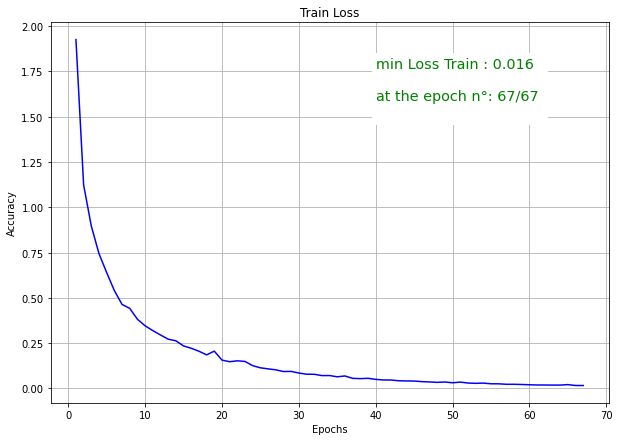

In [ ]:
import matplotlib.pyplot as plt
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'b')
plt.grid()
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.5,"min Loss Train : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('loss_train.png', dpi=fig.dpi)

In [ ]:
min(loss_tr)

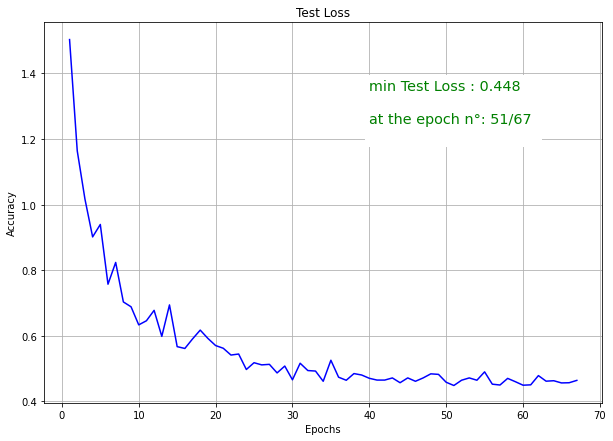

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te,'b')
plt.grid()
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.2,"min Test Loss : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('loss_test.png', dpi=fig.dpi)

In [ ]:
min(loss_te)

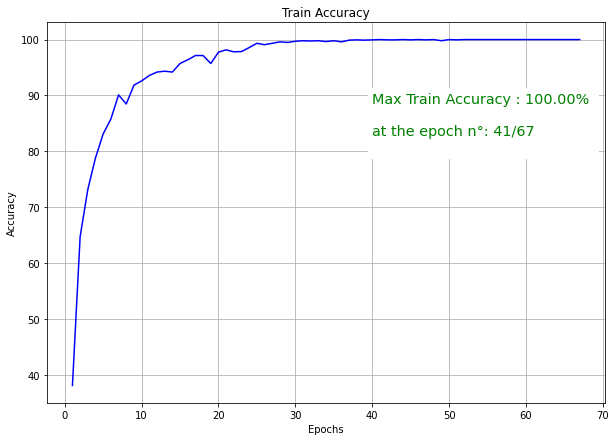

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr,'b')
plt.grid()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,80,"Max Train Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('acc_train.png', dpi=fig.dpi)

In [ ]:
max(acc_tr)

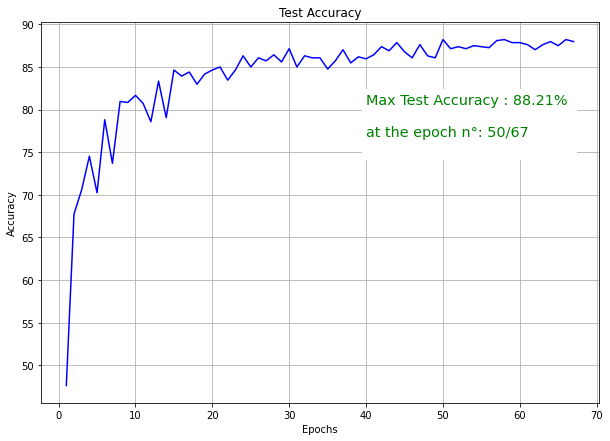

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te,"b")
plt.grid()
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,75,"Max Test Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_te), acc_te.index(max(acc_te))+1,len(acc_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('acc_test.png', dpi=fig.dpi)

In [ ]:
M=max(acc_te)
M,acc_te.index(M)

#SPDAgg+SPDNet

##Data

In [ ]:
class Shreck(Dataset):

  def __init__(self, train=True,transform=None):

    self.transform = transform
    if train:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['data_train']
      self.target = torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['label'] 

    else:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['data_test']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['label'] 

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data=torch.tensor(self.data[idx],requires_grad=False)
    label=self.target[idx].type(torch.LongTensor)
    sample={"data":data,"label":label}
    return sample

##Dataloader

In [ ]:
transformed_dataset = Shreck(train=True)
dataloader = DataLoader(transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=4)

transformed_dataset_val = Shreck(train=False)
dataloader_val = DataLoader(transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=4)

##Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.trans1 = SPDTransform(200, 100)
        self.rect1  = SPDRectified()
        self.tangent = SPDTangentSpace(100)
        self.linear = nn.Linear(5050, 14, bias=True)
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.trans1(x)
        x = self.rect1(x)
        x = self.tangent(x)
        # x = self.dropout(x)
        x = self.linear(x.type(torch.FloatTensor))
        return x

##Model execution

In [ ]:
use_cuda = False
model = Net()
if use_cuda:
  model = model.cuda()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adadelta(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)
optimizer = StiefelMetaOptimizer(optimizer)
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0.0
    total = 0.0
    bar = notebook.tqdm(enumerate(dataloader))
    for batch_idx, sample_batched in bar:
        inputs = torch.tensor(sample_batched['data'],requires_grad=True)
        targets = sample_batched['label'].squeeze()
        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
    
        train_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.item()

        bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1.0), 100.*correct/total, correct, total))
    return (train_loss/(batch_idx+1), 100.*correct/total)

best_acc = 0
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0.0
    total = 0.0
    bar = notebook.tqdm(enumerate(dataloader_val))
    for batch_idx, sample_batched in bar:
        inputs = torch.tensor(sample_batched['data'],requires_grad=True)
        targets = sample_batched['label'].squeeze()

        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.LongTensor))

        test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.item()

        bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    return (test_loss/(batch_idx+1), 100.*correct/total)

In [ ]:
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
start_epoch = 1
for epoch in range(start_epoch, start_epoch+501):
  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/ST-TS+SPDNet1b-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc >= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/ST-TS+SPDNet1b-15-06.pth")


Epoch: 1




Epoch: 2




Epoch: 3




Epoch: 4




Epoch: 5




Epoch: 6




Epoch: 7




Epoch: 8




Epoch: 9




Epoch: 10




Epoch: 11




Epoch: 12




Epoch: 13




Epoch: 14




Epoch: 15




Epoch: 16




Epoch: 17




Epoch: 18




Epoch: 19




Epoch: 20




Epoch: 21




Epoch: 22




Epoch: 23




Epoch: 24




Epoch: 25




Epoch: 26




Epoch: 27




Epoch: 28




Epoch: 29




Epoch: 30




Epoch: 31




Epoch: 32




Epoch: 33




Epoch: 34




Epoch: 35




Epoch: 36




Epoch: 37




Epoch: 38




Epoch: 39




Epoch: 40




Epoch: 41




Epoch: 42




Epoch: 43




Epoch: 44




Epoch: 45




Epoch: 46




Epoch: 47




Epoch: 48




Epoch: 49




Epoch: 50




Epoch: 51




Epoch: 52




Epoch: 53




Epoch: 54




Epoch: 55




Epoch: 56




Epoch: 57




Epoch: 58




Epoch: 59




Epoch: 60




Epoch: 61




Epoch: 62




Epoch: 63




Epoch: 64




Epoch: 65




Epoch: 66




Epoch: 67




Epoch: 68




Epoch: 69




Epoch: 70




Epoch: 71




Epoch: 72




Epoch: 73




Epoch: 74




Epoch: 75




Epoch: 76




Epoch: 77




Epoch: 78




Epoch: 79




Epoch: 80




Epoch: 81




Epoch: 82




Epoch: 83




Epoch: 84




Epoch: 85




Epoch: 86




Epoch: 87




Epoch: 88




Epoch: 89




Epoch: 90




Epoch: 91




Epoch: 92




Epoch: 93




Epoch: 94




Epoch: 95




Epoch: 96




Epoch: 97




Epoch: 98




Epoch: 99




Epoch: 100




Epoch: 101




Epoch: 102




Epoch: 103




Epoch: 104




Epoch: 105




Epoch: 106




Epoch: 107




Epoch: 108




Epoch: 109




Epoch: 110




Epoch: 111




Epoch: 112




Epoch: 113




Epoch: 114




Epoch: 115




Epoch: 116




Epoch: 117




Epoch: 118




Epoch: 119




Epoch: 120




Epoch: 121




Epoch: 122




Epoch: 123




Epoch: 124




Epoch: 125




Epoch: 126




Epoch: 127




Epoch: 128




Epoch: 129




Epoch: 130




Epoch: 131




Epoch: 132




Epoch: 133




Epoch: 134




Epoch: 135




Epoch: 136




Epoch: 137




Epoch: 138




Epoch: 139




Epoch: 140




Epoch: 141




Epoch: 142




Epoch: 143




Epoch: 144




Epoch: 145




Epoch: 146




Epoch: 147




Epoch: 148




Epoch: 149




Epoch: 150




Epoch: 151




Epoch: 152




Epoch: 153




Epoch: 154




Epoch: 155




Epoch: 156




Epoch: 157




Epoch: 158




Epoch: 159




Epoch: 160




Epoch: 161




Epoch: 162




Epoch: 163




Epoch: 164




Epoch: 165




Epoch: 166




Epoch: 167




Epoch: 168




Epoch: 169




Epoch: 170




Epoch: 171




Epoch: 172




Epoch: 173




Epoch: 174




Epoch: 175




Epoch: 176




Epoch: 177




Epoch: 178




Epoch: 179




Epoch: 180




Epoch: 181




Epoch: 182




Epoch: 183




Epoch: 184




Epoch: 185




Epoch: 186




Epoch: 187




Epoch: 188




Epoch: 189




Epoch: 190




Epoch: 191




Epoch: 192




Epoch: 193




Epoch: 194




Epoch: 195




Epoch: 196




Epoch: 197




Epoch: 198




Epoch: 199




Epoch: 200




Epoch: 201




Epoch: 202




Epoch: 203




Epoch: 204




Epoch: 205




Epoch: 206




Epoch: 207




Epoch: 208




Epoch: 209




Epoch: 210




Epoch: 211




Epoch: 212




Epoch: 213




Epoch: 214




Epoch: 215




Epoch: 216




Epoch: 217




Epoch: 218




Epoch: 219




Epoch: 220




Epoch: 221




Epoch: 222




Epoch: 223




Epoch: 224




Epoch: 225




Epoch: 226




Epoch: 227




Epoch: 228




Epoch: 229




Epoch: 230




Epoch: 231




Epoch: 232




Epoch: 233




Epoch: 234




Epoch: 235




Epoch: 236




Epoch: 237




Epoch: 238




Epoch: 239




Epoch: 240




Epoch: 241




Epoch: 242




Epoch: 243




Epoch: 244




Epoch: 245




Epoch: 246




Epoch: 247




Epoch: 248




Epoch: 249




Epoch: 250




Epoch: 251




Epoch: 252




Epoch: 253




Epoch: 254




Epoch: 255




Epoch: 256




Epoch: 257




Epoch: 258




Epoch: 259




Epoch: 260




Epoch: 261




Epoch: 262




Epoch: 263




Epoch: 264




Epoch: 265




Epoch: 266




Epoch: 267




Epoch: 268




Epoch: 269




Epoch: 270




Epoch: 271




Epoch: 272




Epoch: 273




Epoch: 274




Epoch: 275




Epoch: 276




Epoch: 277




Epoch: 278




Epoch: 279




Epoch: 280




Epoch: 281




Epoch: 282




Epoch: 283




Epoch: 284




Epoch: 285




Epoch: 286




Epoch: 287




Epoch: 288




Epoch: 289




Epoch: 290




Epoch: 291




Epoch: 292




Epoch: 293




Epoch: 294




Epoch: 295




Epoch: 296




Epoch: 297




Epoch: 298




Epoch: 299




Epoch: 300




Epoch: 301




Epoch: 302




Epoch: 303




Epoch: 304




Epoch: 305




Epoch: 306




Epoch: 307




Epoch: 308




Epoch: 309




Epoch: 310




Epoch: 311




Epoch: 312




Epoch: 313




Epoch: 314




Epoch: 315




Epoch: 316




Epoch: 317




Epoch: 318




Epoch: 319




Epoch: 320




Epoch: 321




Epoch: 322




Epoch: 323




Epoch: 324




Epoch: 325




Epoch: 326




Epoch: 327




Epoch: 328




Epoch: 329




Epoch: 330




Epoch: 331




Epoch: 332




Epoch: 333




Epoch: 334




Epoch: 335




Epoch: 336




Epoch: 337




Epoch: 338




Epoch: 339




Epoch: 340




Epoch: 341




Epoch: 342




Epoch: 343




Epoch: 344




Epoch: 345




Epoch: 346




Epoch: 347




Epoch: 348




Epoch: 349




Epoch: 350




Epoch: 351




Epoch: 352




Epoch: 353




Epoch: 354




Epoch: 355




Epoch: 356




Epoch: 357




Epoch: 358




Epoch: 359




Epoch: 360




Epoch: 361




Epoch: 362




Epoch: 363




Epoch: 364




Epoch: 365




Epoch: 366




Epoch: 367




Epoch: 368




Epoch: 369




Epoch: 370




Epoch: 371




Epoch: 372




Epoch: 373




Epoch: 374




Epoch: 375




Epoch: 376




Epoch: 377




Epoch: 378




Epoch: 379




Epoch: 380




Epoch: 381




Epoch: 382




Epoch: 383




Epoch: 384




Epoch: 385




Epoch: 386




Epoch: 387




Epoch: 388




Epoch: 389




Epoch: 390




Epoch: 391




Epoch: 392




Epoch: 393




Epoch: 394




Epoch: 395




Epoch: 396




Epoch: 397




Epoch: 398




Epoch: 399




Epoch: 400




Epoch: 401




Epoch: 402




Epoch: 403




Epoch: 404




Epoch: 405




Epoch: 406




Epoch: 407




Epoch: 408




Epoch: 409




Epoch: 410




Epoch: 411




Epoch: 412




Epoch: 413




Epoch: 414




Epoch: 415




Epoch: 416




Epoch: 417




Epoch: 418




Epoch: 419




Epoch: 420




Epoch: 421




Epoch: 422




Epoch: 423




Epoch: 424




Epoch: 425




Epoch: 426




Epoch: 427




Epoch: 428




Epoch: 429




Epoch: 430




Epoch: 431




Epoch: 432




Epoch: 433




Epoch: 434




Epoch: 435




Epoch: 436




Epoch: 437




Epoch: 438




Epoch: 439




Epoch: 440




Epoch: 441




Epoch: 442




Epoch: 443




Epoch: 444




Epoch: 445




Epoch: 446




Epoch: 447




Epoch: 448




Epoch: 449




Epoch: 450


##Plotting results

In [ ]:
loss_train,loss_test,acc_train,acc_test = pickle.load(open("/content/drive/MyDrive/results/results/ST-TS+SPDNet1b-15-06.pkl",'rb'))

min Loss Train : 0.032 
at the epoch n°: 496/501 



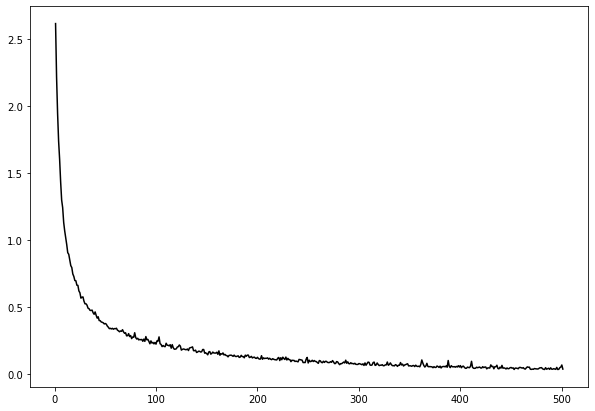

In [ ]:
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'k')
print("min Loss Train : %.3f \nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)))

min  Loss Test : 0.396 
at the epoch n°: 304/501 



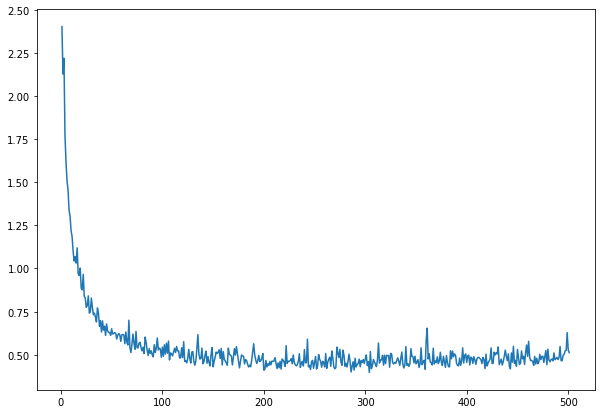

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te)
print("min  Loss Test : %.3f \nat the epoch n°: %d/%d \n"
      %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)))

max  Acc Train  : 99.643 
at the epoch n°: 453/501 



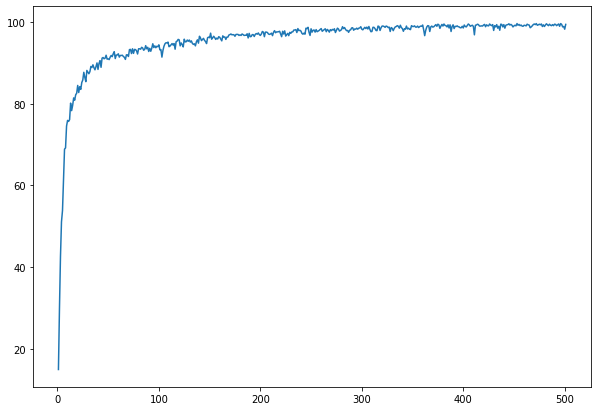

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr)
print("max  Acc Train  : %.3f \nat the epoch n°: %d/%d \n"
      %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)))

max  Acc Test  : 89.405 
at the epoch n°: 287/501 



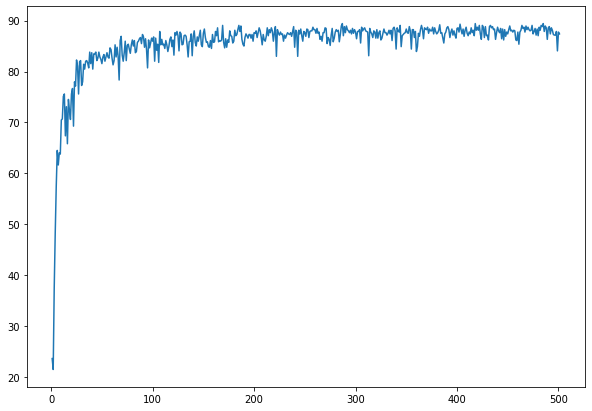

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te)
print("max  Acc Test  : %.3f \nat the epoch n°: %d/%d \n"
      %(max(acc_te), acc_te.index(max(acc_te))+1,len(acc_te)))

In [ ]:
acc_test

{1: 23.69047619047619,
 2: 21.547619047619047,
 3: 37.5,
 4: 48.333333333333336,
 5: 57.5,
 6: 64.52380952380952,
 7: 61.666666666666664,
 8: 64.04761904761905,
 9: 63.80952380952381,
 10: 70.47619047619048,
 11: 70.71428571428571,
 12: 75.11904761904762,
 13: 75.5952380952381,
 14: 67.38095238095238,
 15: 73.0952380952381,
 16: 65.83333333333333,
 17: 74.52380952380952,
 18: 72.38095238095238,
 19: 70.5952380952381,
 20: 75.5952380952381,
 21: 76.66666666666667,
 22: 69.28571428571429,
 23: 77.97619047619048,
 24: 77.14285714285714,
 25: 82.26190476190476,
 26: 81.07142857142857,
 27: 75.5952380952381,
 28: 81.9047619047619,
 29: 82.14285714285714,
 30: 77.26190476190476,
 31: 77.97619047619048,
 32: 81.42857142857143,
 33: 80.47619047619048,
 34: 82.02380952380952,
 35: 82.14285714285714,
 36: 81.66666666666667,
 37: 80.71428571428571,
 38: 83.80952380952381,
 39: 81.54761904761905,
 40: 83.69047619047619,
 41: 80.47619047619048,
 42: 83.45238095238095,
 43: 83.45238095238095,
 44: 8

#SIAMESE NETWORK FC 15-06

##Utils

In [ ]:
def dis(x1,x2):
  return (x1-x2).pow(2).sum(-1).sqrt()

In [ ]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [ ]:
class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllPositivePairSelector(PairSelector):
    """
    Discards embeddings and generates all possible pairs given labels.
    If balance is True, negative pairs are a random sample to match the number of positive samples
    """
    def __init__(self, balance=True):
        super(AllPositivePairSelector, self).__init__()
        self.balance = balance

    def get_pairs(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]
        if self.balance:
            negative_pairs = negative_pairs[torch.randperm(len(negative_pairs))[:len(positive_pairs)]]

        return positive_pairs, negative_pairs


In [ ]:
class HardNegativePairSelector(PairSelector):
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
        super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs


In [ ]:
class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


In [ ]:
def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

In [ ]:
def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None

In [ ]:
def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

In [ ]:
class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

In [ ]:
def HardestNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=hardest_negative,cpu=cpu)


In [ ]:
def RandomNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=random_hard_negative,cpu=cpu)

In [ ]:
def SemihardNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=lambda x: semihard_negative(x, margin),cpu=cpu)

##Metric

In [ ]:
class Metric:
    def __init__(self):
        pass

    def __call__(self, outputs, target, loss):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

    def name(self):
        raise NotImplementedError

In [ ]:
class AccumulatedAccuracyMetric(Metric):
    """
    Works with classification model
    """

    def __init__(self):
        self.correct = 0
        self.total = 0

    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()

    def reset(self):
        self.correct = 0
        self.total = 0

    def value(self):
        return 100 * float(self.correct) / self.total

    def name(self):
        return 'Accuracy'

In [ ]:
class AverageNonzeroTripletsMetric(Metric):
    '''
    Counts average number of nonzero triplets found in minibatches
    '''

    def __init__(self):
        self.values = []

    def __call__(self, outputs, target, loss):
        self.values.append(loss[1])
        return self.value()

    def reset(self):
        self.values = []

    def value(self):
        return np.mean(self.values)

    def name(self):
        return 'Average nonzero triplets'

##Plot

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12','13']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#F2F607','#2DF607','#FF01F3','#E7E2E2','#bcbd22', '#17becf']
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
  plt.figure(figsize=(10,10))
  for i in range(14):
    inds = np.where(targets==i)[0]
    plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
  if xlim:
    plt.xlim(xlim[0], xlim[1])
  if ylim:
    plt.ylim(ylim[0], ylim[1])
  plt.legend(classes)

def extract_embeddings(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 14))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for x in dataloader:
      images=x['data']
      target=x['label']
      if cuda:
          images = images.cuda()
      embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
      labels[k:k+len(images)] = target.numpy()
      k += len(images)
    return embeddings, labels

##Loss Function

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1).sqrt()  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps)))#.sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

##Dataset

In [ ]:
class Shreck(Dataset):

  def __init__(self, train=True,transform=None):

    self.transform = transform
    self.train = train
    if self.train:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['data_train']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['label'] 

    else:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['data_test']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['label'] 

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data=torch.tensor(self.data[idx],requires_grad=False)
    label=self.target[idx].type(torch.LongTensor)
    sample={"data":data,"label":label}
    return sample

In [ ]:
class SiameseShreck(Dataset):

  def __init__(self, Shreck):
    self.train=Shreck.train
    self.transform = Shreck.transform
    if self.train:
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices=[torch.where(self.target==i)[0] for i in range(14)]
      x=self.label_to_indices
      pos_pairs=[[x[m][i].item(),x[m][i+1].item(),1] for m in range(14) for i in range(-1,len(x[m])-1)]+[[x[m][i].item(),x[m][i-10].item(),1] for m in range(14) for i in range(10,len(x[m])-1,10)]
      t=[]
      for m in range(14):
        r1=torch.full((143,),m).tolist()
        r2=random.sample([i for j in range(11) for i in set(range(14))-{m}],13*11)
        r3=random.sample(torch.arange(len(x[m])).tolist()+
                         [random.randint(0,len(x[m])-1) for i in range(143-len(x[m]))],143)
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      neg_pairs=[[x[m][i],x[n][j],0] for m,n,i,j in t]
      self.pairs=random.sample(pos_pairs+neg_pairs,len(pos_pairs+neg_pairs))

    else:
      random_state = np.random.RandomState(29)
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices={i:torch.where(self.target==i)[0] for i in range(14)}
      x=self.label_to_indices
      pos_pairs = [[i,random_state.choice(self.label_to_indices[self.target[i].item()]),1]
                  for i in range(0, len(self.data), 2)]
      t=[]
      for m in range(14):
        r1=torch.full((30,),m).tolist()
        r2=random.sample(list(set(range(14))-{m})+[random.choice(list(set(range(14))-{m})) for i in range(17)],30)
        r3=random.sample(torch.arange(len(x[m])).tolist(),30)
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      neg_pairs=[[x[m][i],x[n][j],0] for m,n,i,j in t]
      self.pairs =random.sample(pos_pairs + neg_pairs, len(pos_pairs + neg_pairs))

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self,idx):
    s1 = torch.tensor(self.data[self.pairs[idx][0]],requires_grad=False)
    s2 = torch.tensor(self.data[self.pairs[idx][1]],requires_grad=False)
    i1=self.pairs[idx][2]
    return {'data':(s1,s2),'label':i1}

##Dataloader

In [ ]:
transformed_dataset = Shreck(train=True)
train_loader = DataLoader(transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

transformed_dataset_val = Shreck(train=False)
test_loader = DataLoader(transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
siamese_transformed_dataset = SiameseShreck(Shreck())
siamese_train_loader = DataLoader(siamese_transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

siamese_transformed_dataset_val = SiameseShreck(Shreck(train=False))
siamese_test_loader = DataLoader(siamese_transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
rep=torch.zeros(14,200,200)
for j in range(14):
  i=0
  while int(train_loader.dataset[i]['label'].item())!=j:
    i+=1
  rep[j]=train_loader.dataset[i]['data']

In [ ]:
tu=[train_loader.dataset[i]['data'].unsqueeze(0) for i in range(1960)]
tot=torch.cat(tuple(tu),0)
tu=[train_loader.dataset[i]['label'].unsqueeze(0) for i in range(1960)]
tot_label=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['data'].unsqueeze(0) for i in range(840)]
tot_test=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['label'].unsqueeze(0) for i in range(840)]
tot_label_test=torch.cat(tuple(tu),0)

##Training & Test

In [ ]:
def train(epoch,train_loader, model, loss_fn, optimizer, cuda,tot,tot_label,rep,m):
  model.train()
  total_loss = 0
  correct = 0.0
  total = 0.0
  bar = notebook.tqdm(enumerate(train_loader))
  for batch_idx, x in bar:
    data=x['data']
    target=x['label'].type(torch.LongTensor)
    if not type(data) in (tuple, list):
      data = (data,)
    if cuda:
      data = tuple(d.cuda() for d in data)
      if target is not None:
        target = target.cuda()
    optimizer.zero_grad()
    outputs = model(*data)

    if type(outputs) not in (tuple, list):
      outputs = (outputs,)

    loss_inputs = outputs
    if target is not None:
      targets = (target,)
      loss_inputs += targets
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    total_loss += loss.item()
    total += target.size(0)
    loss.backward()
    optimizer.step()
    bar.set_description('Loss: %.3f |(%d/%d)'% (total_loss/(batch_idx+1.0),0, total))
    if batch_idx==138:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
          % (total_loss/(batch_idx+1),100.*Acc/len(x), Acc,1960))
  return (total_loss/(batch_idx+1), 100.*Acc/len(x))

In [ ]:
def test(epoch,dataloader_val,model, loss_fn, cuda,tot,tot_label,rep,m):
  model.eval()
  test_loss = 0
  total = 0.0
  bar = notebook.tqdm(enumerate(dataloader_val))
  for batch_idx, x in bar:
    data=x['data']
    target=x['label'].type(torch.LongTensor)

    if not type(data) in (tuple, list):
      data = (data,)
    if cuda:
      data = tuple(d.cuda() for d in data)
      if target is not None:
        target = target.cuda()
    outputs = model(*data)

    if type(outputs) not in (tuple, list):
      outputs = (outputs,)

    loss_inputs = outputs
    if target is not None:
      targets = (target,)
      loss_inputs += targets
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    test_loss += loss.data.item()
    total += target.size(0)

    bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
      % (test_loss/(batch_idx+1), 0., 0, total))
    if batch_idx==27:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
                        % (test_loss/(batch_idx+1),100.*Acc/len(x), Acc,total))
  return (test_loss/(batch_idx+1), 100.*Acc/len(x))

##Model

###FC

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.tangent = SPDTangentSpace(200)
    self.linear = nn.Linear(20100, 14, bias=True)
    # self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.tangent(x)
    # x = self.dropout(x)
    x = self.linear(x)
    return x

  def get_embedding(self,x):
    return self.forward(x)

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

####margin=1

In [ ]:
margin = 1
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
#model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+ts+fc13-06.pth"))
#loss_train,loss_test,acc_train,acc_test=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_fc+rep-13-06.pkl", 'rb'))
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  """with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-15-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-15-06.pth")"""

####Margin=10

In [ ]:
margin = 10
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=10-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06_best.pth")



Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :




Epoch  29 :




Epoch  30 :




Epoch  31 :




Epoch  32 :




Epoch  33 :




Epoch  34 :




Epoch  35 :




Epoch  36 :




Epoch  37 :




Epoch  38 :




Epoch  39 :




Epoch  40 :




Epoch  41 :




Epoch  42 :




Epoch  43 :




Epoch  44 :




Epoch  45 :




Epoch  46 :




Epoch  47 :




Epoch  48 :




Epoch  49 :




Epoch  50 :




Epoch  51 :




Epoch  52 :




Epoch  53 :


####Margin=20

In [ ]:
margin = 20
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=20-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=20-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=20-15-06_best.pth")



Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :


KeyboardInterrupt: ignored

####margin=7

In [ ]:
margin = 7
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=7-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=7-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=7-15-06_best.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :




Epoch  29 :




Epoch  30 :




Epoch  31 :




Epoch  32 :




Epoch  33 :




Epoch  34 :




Epoch  35 :




Epoch  36 :




Epoch  37 :




Epoch  38 :




Epoch  39 :




Epoch  40 :




Epoch  41 :




Epoch  42 :




Epoch  43 :




Epoch  44 :




Epoch  45 :




Epoch  46 :




Epoch  47 :




Epoch  48 :




Epoch  49 :




Epoch  50 :




Epoch  51 :




Epoch  52 :




Epoch  53 :




Epoch  54 :




Epoch  55 :




Epoch  56 :




Epoch  57 :




Epoch  58 :




Epoch  59 :




Epoch  60 :




Epoch  61 :




Epoch  62 :




Epoch  63 :




Epoch  64 :




Epoch  65 :




Epoch  66 :




Epoch  67 :




Epoch  68 :




Epoch  69 :




Epoch  70 :




Epoch  71 :




Epoch  72 :




Epoch  73 :




Epoch  74 :




Epoch  75 :




Epoch  76 :




Epoch  77 :




Epoch  78 :




Epoch  79 :




Epoch  80 :




Epoch  81 :




Epoch  82 :




Epoch  83 :




Epoch  84 :




Epoch  85 :




Epoch  86 :




Epoch  87 :




Epoch  88 :




Epoch  89 :




Epoch  90 :




Epoch  91 :




Epoch  92 :




Epoch  93 :




Epoch  94 :




Epoch  95 :




Epoch  96 :




Epoch  97 :




Epoch  98 :




Epoch  99 :




Epoch  100 :




Epoch  101 :




Epoch  102 :




Epoch  103 :




Epoch  104 :




Epoch  105 :




Epoch  106 :




Epoch  107 :




Epoch  108 :




Epoch  109 :




Epoch  110 :




Epoch  111 :




Epoch  112 :




Epoch  113 :




Epoch  114 :




Epoch  115 :




Epoch  116 :




Epoch  117 :




Epoch  118 :




Epoch  119 :




Epoch  120 :




Epoch  121 :




Epoch  122 :




Epoch  123 :




Epoch  124 :




Epoch  125 :




Epoch  126 :




Epoch  127 :




Epoch  128 :




Epoch  129 :




Epoch  130 :




Epoch  131 :




Epoch  132 :




Epoch  133 :




Epoch  134 :




Epoch  135 :




Epoch  136 :




Epoch  137 :




Epoch  138 :




Epoch  139 :




Epoch  140 :




Epoch  141 :




Epoch  142 :




Epoch  143 :




Epoch  144 :




Epoch  145 :




Epoch  146 :




Epoch  147 :




Epoch  148 :




Epoch  149 :




Epoch  150 :




Epoch  151 :




Epoch  152 :




Epoch  153 :




Epoch  154 :




Epoch  155 :




Epoch  156 :




Epoch  157 :




Epoch  158 :




Epoch  159 :




Epoch  160 :




Epoch  161 :




Epoch  162 :




Epoch  163 :




Epoch  164 :




Epoch  165 :




Epoch  166 :




Epoch  167 :




Epoch  168 :




Epoch  169 :




Epoch  170 :




Epoch  171 :




Epoch  172 :




Epoch  173 :




Epoch  174 :




Epoch  175 :




Epoch  176 :




Epoch  177 :




Epoch  178 :




Epoch  179 :




Epoch  180 :




Epoch  181 :




Epoch  182 :




Epoch  183 :




Epoch  184 :




Epoch  185 :




Epoch  186 :




Epoch  187 :




Epoch  188 :




Epoch  189 :




Epoch  190 :




Epoch  191 :




Epoch  192 :




Epoch  193 :




Epoch  194 :




Epoch  195 :




Epoch  196 :




Epoch  197 :




Epoch  198 :




Epoch  199 :




Epoch  200 :




Epoch  201 :




Epoch  202 :




Epoch  203 :




Epoch  204 :




Epoch  205 :




Epoch  206 :




Epoch  207 :




Epoch  208 :




Epoch  209 :




Epoch  210 :




Epoch  211 :




Epoch  212 :




Epoch  213 :




Epoch  214 :




Epoch  215 :




Epoch  216 :




Epoch  217 :




Epoch  218 :




Epoch  219 :




Epoch  220 :




Epoch  221 :




Epoch  222 :




Epoch  223 :




Epoch  224 :




Epoch  225 :




Epoch  226 :




Epoch  227 :




Epoch  228 :




Epoch  229 :




Epoch  230 :




Epoch  231 :




Epoch  232 :




Epoch  233 :




Epoch  234 :




Epoch  235 :




Epoch  236 :




Epoch  237 :




Epoch  238 :




Epoch  239 :




Epoch  240 :




Epoch  241 :




Epoch  242 :




Epoch  243 :


####margin=8

In [ ]:
margin = 8
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=8-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=8-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=8-15-06_best.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :


KeyboardInterrupt: ignored

####Dispersion

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06_best.pth"))

<All keys matched successfully>

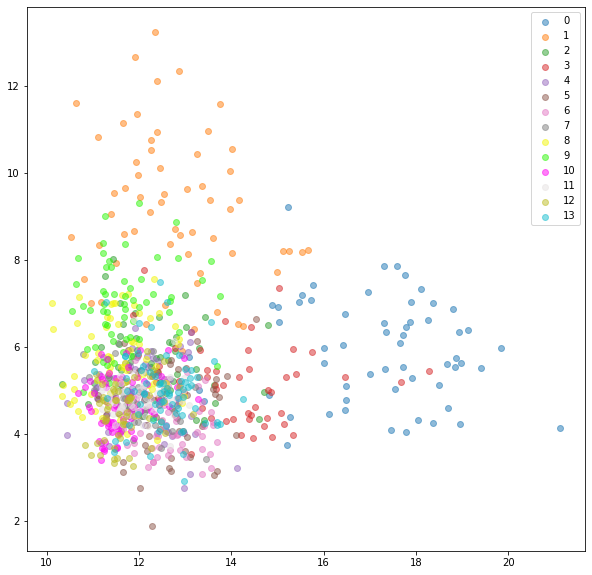

In [ ]:
d,l=extract_embeddings(test_loader,model)
plot_embeddings(d,l)

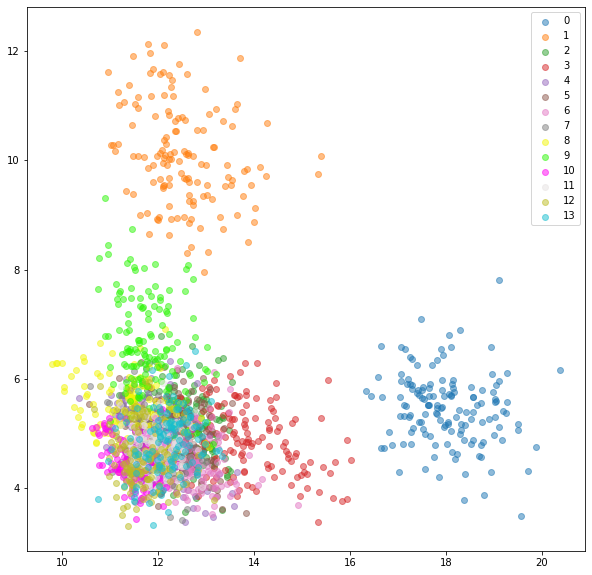

In [ ]:
d,l=extract_embeddings(train_loader,model)
plot_embeddings(d,l)

In [ ]:
d = torch.from_numpy(d)
l = torch.from_numpy(l)

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
id=torch.tensor([[i,j] for i in range(839) for j in range(i+1,840)]).T
dis_matrix[id[0],id[1]].size()

In [ ]:
c=dis_matrix[:58,58:]
c[c>1].size(0)/(c.size(0)*c.size(1))

In [ ]:
c=dis_matrix[:58,58:]
c[c<2].size(0)/(c.size(0)**2)

In [ ]:
c=l.sort()[0]
for i in range(14):
  print(len(c[c==i]),end=", ")

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]

In [ ]:
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
dis_matrix[:142,142:].mean(),dis_matrix[:142,:142].mean()

In [ ]:
dis_matrix.max(),(dis_matrix.triu(1)+1000*torch.ones(1960,1960).tril()).min()

####Plotting results

In [ ]:
L=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_fc+rep-13-06.pkl",'rb'))

In [ ]:
loss_train=L[0]
loss_test=L[1]
acc_train=L[2]
acc_test=L[3]

In [ ]:
import matplotlib.pyplot as plt
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'b')
plt.grid()
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.5,"min Loss Train : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_train.png', dpi=fig.dpi)

In [ ]:
min(loss_tr)

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te,'b')
plt.grid()
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.2,"min Test Loss : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_test.png', dpi=fig.dpi)

In [ ]:
min(loss_te)

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr,'b')
plt.grid()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,80,"Max Train Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_train.png', dpi=fig.dpi)

In [ ]:
max(acc_tr)

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te,"b")
plt.grid()
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,75,"Max Test Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_te)+0.47, acc_te.index(max(acc_te))+1,len(acc_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_test.png', dpi=fig.dpi)

In [ ]:
M=max(acc_te)
M,acc_te.index(M)

#SIAMESE NETWORK SPDNET 19-06

##Utils

In [ ]:
def dis(x1,x2):
  return (x1-x2).pow(2).sum(-1).sqrt()

In [ ]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [ ]:
class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllPositivePairSelector(PairSelector):
    """
    Discards embeddings and generates all possible pairs given labels.
    If balance is True, negative pairs are a random sample to match the number of positive samples
    """
    def __init__(self, balance=True):
        super(AllPositivePairSelector, self).__init__()
        self.balance = balance

    def get_pairs(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]
        if self.balance:
            negative_pairs = negative_pairs[torch.randperm(len(negative_pairs))[:len(positive_pairs)]]

        return positive_pairs, negative_pairs


In [ ]:
class HardNegativePairSelector(PairSelector):
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
        super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs


In [ ]:
class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


In [ ]:
def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

In [ ]:
def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None

In [ ]:
def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

In [ ]:
class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

In [ ]:
def HardestNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=hardest_negative,cpu=cpu)


In [ ]:
def RandomNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=random_hard_negative,cpu=cpu)

In [ ]:
def SemihardNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=lambda x: semihard_negative(x, margin),cpu=cpu)

##Metric

In [ ]:
class Metric:
    def __init__(self):
        pass

    def __call__(self, outputs, target, loss):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

    def name(self):
        raise NotImplementedError

In [ ]:
class AccumulatedAccuracyMetric(Metric):
    """
    Works with classification model
    """

    def __init__(self):
        self.correct = 0
        self.total = 0

    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()

    def reset(self):
        self.correct = 0
        self.total = 0

    def value(self):
        return 100 * float(self.correct) / self.total

    def name(self):
        return 'Accuracy'

In [ ]:
class AverageNonzeroTripletsMetric(Metric):
    '''
    Counts average number of nonzero triplets found in minibatches
    '''

    def __init__(self):
        self.values = []

    def __call__(self, outputs, target, loss):
        self.values.append(loss[1])
        return self.value()

    def reset(self):
        self.values = []

    def value(self):
        return np.mean(self.values)

    def name(self):
        return 'Average nonzero triplets'

##Plot

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12','13']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#F2F607','#2DF607','#FF01F3','#E7E2E2','#bcbd22', '#17becf']
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
  plt.figure(figsize=(10,10))
  for i in range(14):
    inds = np.where(targets==i)[0]
    plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
  if xlim:
    plt.xlim(xlim[0], xlim[1])
  if ylim:
    plt.ylim(ylim[0], ylim[1])
  plt.legend(classes)

def extract_embeddings(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 14))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for x in dataloader:
      images=x['data']
      target=x['label']
      if cuda:
          images = images.cuda()
      embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
      labels[k:k+len(images)] = target.numpy()
      k += len(images)
    return embeddings, labels

##Loss Function

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1).sqrt()  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps)))#.sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

##Dataset

In [ ]:
class Shreck(Dataset):

  def __init__(self, train=True,transform=None):

    self.transform = transform
    self.train = train
    if self.train:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['data_train']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['label'] 

    else:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['data_test']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['label'] 

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data=torch.tensor(self.data[idx],requires_grad=False)
    label=self.target[idx].type(torch.LongTensor)
    sample={"data":data,"label":label}
    return sample

In [ ]:
class SiameseShreck(Dataset):

  def __init__(self, Shreck):
    self.train=Shreck.train
    self.transform = Shreck.transform
    if self.train:
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices=[torch.where(self.target==i)[0] for i in range(14)]
      x=self.label_to_indices
      pos_pairs=[[x[m][i].item(),x[m][i+1].item(),1] for m in range(14) for i in range(-1,len(x[m])-1)]+[[x[m][i].item(),x[m][i-10].item(),1] for m in range(14) for i in range(10,len(x[m])-1,10)]
      t=[]
      for m in range(14):
        r1=torch.full((143,),m).tolist()
        r2=random.sample([i for j in range(11) for i in set(range(14))-{m}],13*11)
        r3=random.sample(torch.arange(len(x[m])).tolist()+
                         [random.randint(0,len(x[m])-1) for i in range(143-len(x[m]))],143)
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      neg_pairs=[[x[m][i],x[n][j],0] for m,n,i,j in t]
      self.pairs=random.sample(pos_pairs+neg_pairs,len(pos_pairs+neg_pairs))

    else:
      random_state = np.random.RandomState(29)
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices={i:torch.where(self.target==i)[0] for i in range(14)}
      x=self.label_to_indices
      pos_pairs = [[i,random_state.choice(self.label_to_indices[self.target[i].item()]),1]
                  for i in range(0, len(self.data), 2)]
      t=[]
      for m in range(14):
        r1=torch.full((30,),m).tolist()
        r2=random.sample(list(set(range(14))-{m})+[random.choice(list(set(range(14))-{m})) for i in range(17)],30)
        r3=random.sample(torch.arange(len(x[m])).tolist(),30)
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      neg_pairs=[[x[m][i],x[n][j],0] for m,n,i,j in t]
      self.pairs =random.sample(pos_pairs + neg_pairs, len(pos_pairs + neg_pairs))

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self,idx):
    s1 = torch.tensor(self.data[self.pairs[idx][0]],requires_grad=False)
    s2 = torch.tensor(self.data[self.pairs[idx][1]],requires_grad=False)
    i1=self.pairs[idx][2]
    return {'data':(s1,s2),'label':i1}

##Dataloader

In [ ]:
transformed_dataset = Shreck(train=True)
train_loader = DataLoader(transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

transformed_dataset_val = Shreck(train=False)
test_loader = DataLoader(transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
siamese_transformed_dataset = SiameseShreck(Shreck())
siamese_train_loader = DataLoader(siamese_transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

siamese_transformed_dataset_val = SiameseShreck(Shreck(train=False))
siamese_test_loader = DataLoader(siamese_transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
rep=torch.zeros(14,200,200)
for j in range(14):
  i=0
  while int(train_loader.dataset[i]['label'].item())!=j:
    i+=1
  rep[j]=train_loader.dataset[i]['data']

In [ ]:
tu=[train_loader.dataset[i]['data'].unsqueeze(0) for i in range(1960)]
tot=torch.cat(tuple(tu),0)
tu=[train_loader.dataset[i]['label'].unsqueeze(0) for i in range(1960)]
tot_label=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['data'].unsqueeze(0) for i in range(840)]
tot_test=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['label'].unsqueeze(0) for i in range(840)]
tot_label_test=torch.cat(tuple(tu),0)

##Training & Test

In [ ]:
def train(epoch,train_loader, model, loss_fn, optimizer, cuda,tot,tot_label,rep,m):
  model.train()
  total_loss = 0
  correct = 0.0
  total = 0.0
  bar = notebook.tqdm(enumerate(train_loader))
  for batch_idx, x in bar:
    data=x['data']
    target=x['label'].type(torch.LongTensor)
    if not type(data) in (tuple, list):
      data = (data,)
    if cuda:
      data = tuple(d.cuda() for d in data)
      if target is not None:
        target = target.cuda()
    optimizer.zero_grad()
    outputs = model(*data)

    if type(outputs) not in (tuple, list):
      outputs = (outputs,)

    loss_inputs = outputs
    if target is not None:
      targets = (target,)
      loss_inputs += targets
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    total_loss += loss.item()
    total += target.size(0)
    loss.backward()
    optimizer.step()
    bar.set_description('Loss: %.3f |(%d/%d)'% (total_loss/(batch_idx+1.0),0, total))
    if batch_idx==138:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
          % (total_loss/(batch_idx+1),100.*Acc/len(x), Acc,1960))
  return (total_loss/(batch_idx+1), 100.*Acc/len(x))

In [ ]:
def test(epoch,dataloader_val,model, loss_fn, cuda,tot,tot_label,rep,m):
  model.eval()
  test_loss = 0
  total = 0.0
  bar = notebook.tqdm(enumerate(dataloader_val))
  for batch_idx, x in bar:
    data=x['data']
    target=x['label'].type(torch.LongTensor)

    if not type(data) in (tuple, list):
      data = (data,)
    if cuda:
      data = tuple(d.cuda() for d in data)
      if target is not None:
        target = target.cuda()
    outputs = model(*data)

    if type(outputs) not in (tuple, list):
      outputs = (outputs,)

    loss_inputs = outputs
    if target is not None:
      targets = (target,)
      loss_inputs += targets
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    test_loss += loss.data.item()
    total += target.size(0)

    bar.set_description('Loss: %.3f | (%d/%d)'
      % (test_loss/(batch_idx+1), 0, total))
    if batch_idx==27:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
                        % (test_loss/(batch_idx+1),100.*Acc/len(x), Acc,total))
  return (test_loss/(batch_idx+1), 100.*Acc/len(x))

##SPDNET

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.trans1 = SPDTransform(200, 100)
        self.rect1  = SPDRectified()
        self.tangent = SPDTangentSpace(100)
        self.linear = nn.Linear(5050, 14, bias=True)
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.trans1(x)
        x = self.rect1(x)
        x = self.tangent(x)
        # x = self.dropout(x)
        x = self.linear(x.type(torch.FloatTensor))
        return x

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

##Model

###Loss Function Euclidean

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1).sqrt()  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps)))#.sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

####margin=1

In [ ]:
margin = 1
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+SPDNet1b-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_spdnet-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+spdnet-15-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+spdnet-15-06.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :




Epoch  29 :




Epoch  30 :




Epoch  31 :




Epoch  32 :




Epoch  33 :




Epoch  34 :




Epoch  35 :




Epoch  36 :




Epoch  37 :




Epoch  38 :




Epoch  39 :




Epoch  40 :




Epoch  41 :




Epoch  42 :




Epoch  43 :




Epoch  44 :




Epoch  45 :




Epoch  46 :




Epoch  47 :




Epoch  48 :




Epoch  49 :




Epoch  50 :




Epoch  51 :




Epoch  52 :




Epoch  53 :




Epoch  54 :




Epoch  55 :




Epoch  56 :




Epoch  57 :




Epoch  58 :




Epoch  59 :




Epoch  60 :




Epoch  61 :




Epoch  62 :




Epoch  63 :




Epoch  64 :




Epoch  65 :




Epoch  66 :




Epoch  67 :




Epoch  68 :




Epoch  69 :




Epoch  70 :




Epoch  71 :




Epoch  72 :




Epoch  73 :




Epoch  74 :




Epoch  75 :




Epoch  76 :




Epoch  77 :




Epoch  78 :




Epoch  79 :




Epoch  80 :




Epoch  81 :




Epoch  82 :




Epoch  83 :




Epoch  84 :




Epoch  85 :




Epoch  86 :




Epoch  87 :




Epoch  88 :




Epoch  89 :




Epoch  90 :




Epoch  91 :




Epoch  92 :




Epoch  93 :




Epoch  94 :




Epoch  95 :




Epoch  96 :




Epoch  97 :




Epoch  98 :




Epoch  99 :




Epoch  100 :




Epoch  101 :




Epoch  102 :




Epoch  103 :




Epoch  104 :




Epoch  105 :




Epoch  106 :




Epoch  107 :




Epoch  108 :




Epoch  109 :




Epoch  110 :




Epoch  111 :




Epoch  112 :




Epoch  113 :




Epoch  114 :




Epoch  115 :




Epoch  116 :




Epoch  117 :




Epoch  118 :




Epoch  119 :




Epoch  120 :




Epoch  121 :


####Margin=10

In [ ]:
margin = 10
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=10-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06_best.pth")



Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :




Epoch  29 :




Epoch  30 :




Epoch  31 :




Epoch  32 :




Epoch  33 :




Epoch  34 :




Epoch  35 :




Epoch  36 :




Epoch  37 :




Epoch  38 :




Epoch  39 :




Epoch  40 :




Epoch  41 :




Epoch  42 :




Epoch  43 :




Epoch  44 :




Epoch  45 :




Epoch  46 :




Epoch  47 :




Epoch  48 :




Epoch  49 :




Epoch  50 :




Epoch  51 :




Epoch  52 :




Epoch  53 :


####Margin=20

In [ ]:
margin = 20
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=20-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=20-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=20-15-06_best.pth")



Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :


KeyboardInterrupt: ignored

####margin=7

In [ ]:
margin = 7
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=7-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=7-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=7-15-06_best.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :




Epoch  29 :




Epoch  30 :




Epoch  31 :




Epoch  32 :




Epoch  33 :




Epoch  34 :




Epoch  35 :




Epoch  36 :




Epoch  37 :




Epoch  38 :




Epoch  39 :




Epoch  40 :




Epoch  41 :




Epoch  42 :




Epoch  43 :




Epoch  44 :




Epoch  45 :




Epoch  46 :




Epoch  47 :




Epoch  48 :




Epoch  49 :




Epoch  50 :




Epoch  51 :




Epoch  52 :




Epoch  53 :




Epoch  54 :




Epoch  55 :




Epoch  56 :




Epoch  57 :




Epoch  58 :




Epoch  59 :




Epoch  60 :




Epoch  61 :




Epoch  62 :




Epoch  63 :




Epoch  64 :




Epoch  65 :




Epoch  66 :




Epoch  67 :




Epoch  68 :




Epoch  69 :




Epoch  70 :




Epoch  71 :




Epoch  72 :




Epoch  73 :




Epoch  74 :




Epoch  75 :




Epoch  76 :




Epoch  77 :




Epoch  78 :




Epoch  79 :




Epoch  80 :




Epoch  81 :




Epoch  82 :




Epoch  83 :




Epoch  84 :




Epoch  85 :




Epoch  86 :




Epoch  87 :




Epoch  88 :




Epoch  89 :




Epoch  90 :




Epoch  91 :




Epoch  92 :




Epoch  93 :




Epoch  94 :




Epoch  95 :




Epoch  96 :




Epoch  97 :




Epoch  98 :




Epoch  99 :




Epoch  100 :




Epoch  101 :




Epoch  102 :




Epoch  103 :




Epoch  104 :




Epoch  105 :




Epoch  106 :




Epoch  107 :




Epoch  108 :




Epoch  109 :




Epoch  110 :




Epoch  111 :




Epoch  112 :




Epoch  113 :




Epoch  114 :




Epoch  115 :




Epoch  116 :




Epoch  117 :




Epoch  118 :




Epoch  119 :




Epoch  120 :




Epoch  121 :




Epoch  122 :




Epoch  123 :




Epoch  124 :




Epoch  125 :




Epoch  126 :




Epoch  127 :




Epoch  128 :




Epoch  129 :




Epoch  130 :




Epoch  131 :




Epoch  132 :




Epoch  133 :




Epoch  134 :




Epoch  135 :




Epoch  136 :




Epoch  137 :




Epoch  138 :




Epoch  139 :




Epoch  140 :




Epoch  141 :




Epoch  142 :




Epoch  143 :




Epoch  144 :




Epoch  145 :




Epoch  146 :




Epoch  147 :




Epoch  148 :




Epoch  149 :




Epoch  150 :




Epoch  151 :




Epoch  152 :




Epoch  153 :




Epoch  154 :




Epoch  155 :




Epoch  156 :




Epoch  157 :




Epoch  158 :




Epoch  159 :




Epoch  160 :




Epoch  161 :




Epoch  162 :




Epoch  163 :




Epoch  164 :




Epoch  165 :




Epoch  166 :




Epoch  167 :




Epoch  168 :




Epoch  169 :




Epoch  170 :




Epoch  171 :




Epoch  172 :




Epoch  173 :




Epoch  174 :




Epoch  175 :




Epoch  176 :




Epoch  177 :




Epoch  178 :




Epoch  179 :




Epoch  180 :




Epoch  181 :




Epoch  182 :




Epoch  183 :




Epoch  184 :




Epoch  185 :




Epoch  186 :




Epoch  187 :




Epoch  188 :




Epoch  189 :




Epoch  190 :




Epoch  191 :




Epoch  192 :




Epoch  193 :




Epoch  194 :




Epoch  195 :




Epoch  196 :




Epoch  197 :




Epoch  198 :




Epoch  199 :




Epoch  200 :




Epoch  201 :




Epoch  202 :




Epoch  203 :




Epoch  204 :




Epoch  205 :




Epoch  206 :




Epoch  207 :




Epoch  208 :




Epoch  209 :




Epoch  210 :




Epoch  211 :




Epoch  212 :




Epoch  213 :




Epoch  214 :




Epoch  215 :




Epoch  216 :




Epoch  217 :




Epoch  218 :




Epoch  219 :




Epoch  220 :




Epoch  221 :




Epoch  222 :




Epoch  223 :




Epoch  224 :




Epoch  225 :




Epoch  226 :




Epoch  227 :




Epoch  228 :




Epoch  229 :




Epoch  230 :




Epoch  231 :




Epoch  232 :




Epoch  233 :




Epoch  234 :




Epoch  235 :




Epoch  236 :




Epoch  237 :




Epoch  238 :




Epoch  239 :




Epoch  240 :




Epoch  241 :




Epoch  242 :




Epoch  243 :


####margin=8

In [ ]:
margin = 8
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=8-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=8-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=8-15-06_best.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :


KeyboardInterrupt: ignored

####Dispersion

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06_best.pth"))

<All keys matched successfully>

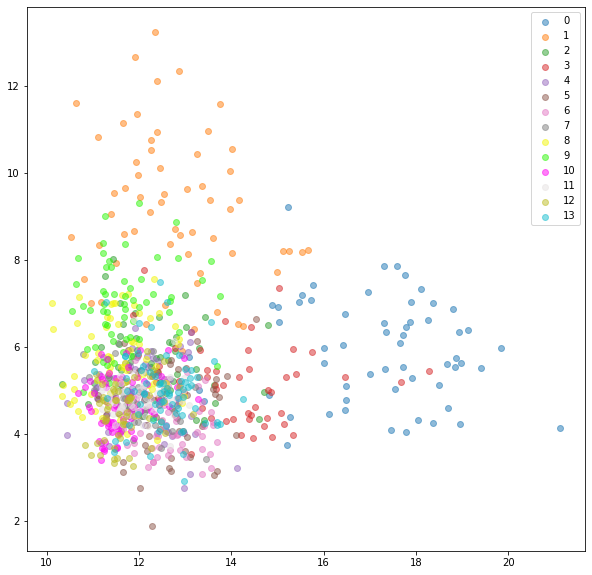

In [ ]:
d,l=extract_embeddings(test_loader,model)
plot_embeddings(d,l)

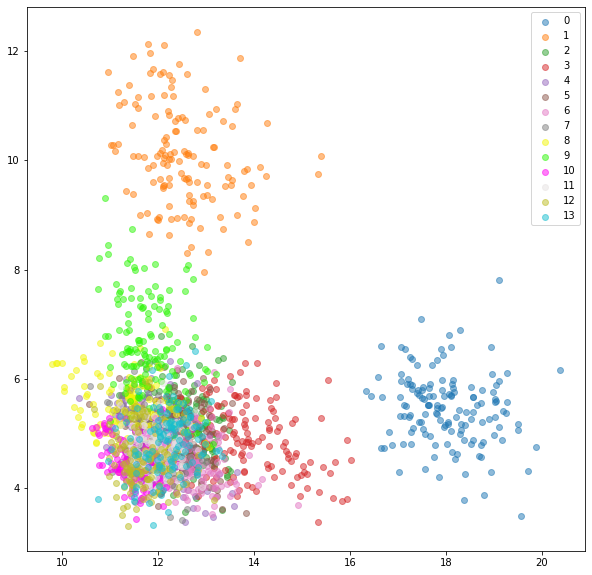

In [ ]:
d,l=extract_embeddings(train_loader,model)
plot_embeddings(d,l)

In [ ]:
d = torch.from_numpy(d)
l = torch.from_numpy(l)

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
id=torch.tensor([[i,j] for i in range(839) for j in range(i+1,840)]).T
dis_matrix[id[0],id[1]].size()

In [ ]:
c=dis_matrix[:58,58:]
c[c>1].size(0)/(c.size(0)*c.size(1))

In [ ]:
c=dis_matrix[:58,58:]
c[c<2].size(0)/(c.size(0)**2)

In [ ]:
c=l.sort()[0]
for i in range(14):
  print(len(c[c==i]),end=", ")

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]

In [ ]:
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
dis_matrix[:142,142:].mean(),dis_matrix[:142,:142].mean()

In [ ]:
dis_matrix.max(),(dis_matrix.triu(1)+1000*torch.ones(1960,1960).tril()).min()

####Plotting results

In [ ]:
L=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_fc+rep-13-06.pkl",'rb'))

In [ ]:
loss_train=L[0]
loss_test=L[1]
acc_train=L[2]
acc_test=L[3]

In [ ]:
import matplotlib.pyplot as plt
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'b')
plt.grid()
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.5,"min Loss Train : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_train.png', dpi=fig.dpi)

In [ ]:
min(loss_tr)

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te,'b')
plt.grid()
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.2,"min Test Loss : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_test.png', dpi=fig.dpi)

In [ ]:
min(loss_te)

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr,'b')
plt.grid()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,80,"Max Train Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_train.png', dpi=fig.dpi)

In [ ]:
max(acc_tr)

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te,"b")
plt.grid()
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,75,"Max Test Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_te)+0.47, acc_te.index(max(acc_te))+1,len(acc_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_test.png', dpi=fig.dpi)

In [ ]:
M=max(acc_te)
M,acc_te.index(M)

#SIAMESE NETWORK EDITED



##Utils

In [ ]:
def dis(x1,x2):
  return (x1-x2).pow(2).sum(-1).sqrt()

In [ ]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [ ]:
class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllPositivePairSelector(PairSelector):
    """
    Discards embeddings and generates all possible pairs given labels.
    If balance is True, negative pairs are a random sample to match the number of positive samples
    """
    def __init__(self, balance=True):
        super(AllPositivePairSelector, self).__init__()
        self.balance = balance

    def get_pairs(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]
        if self.balance:
            negative_pairs = negative_pairs[torch.randperm(len(negative_pairs))[:len(positive_pairs)]]

        return positive_pairs, negative_pairs


In [ ]:
class HardNegativePairSelector(PairSelector):
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
        super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs


In [ ]:
class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


In [ ]:
def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

In [ ]:
def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None

In [ ]:
def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

In [ ]:
class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

In [ ]:
def HardestNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=hardest_negative,cpu=cpu)


In [ ]:
def RandomNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=random_hard_negative,cpu=cpu)

In [ ]:
def SemihardNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=lambda x: semihard_negative(x, margin),cpu=cpu)

##Metric

In [ ]:
class Metric:
    def __init__(self):
        pass

    def __call__(self, outputs, target, loss):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

    def name(self):
        raise NotImplementedError

In [ ]:
class AccumulatedAccuracyMetric(Metric):
    """
    Works with classification model
    """

    def __init__(self):
        self.correct = 0
        self.total = 0

    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()

    def reset(self):
        self.correct = 0
        self.total = 0

    def value(self):
        return 100 * float(self.correct) / self.total

    def name(self):
        return 'Accuracy'

In [ ]:
class AverageNonzeroTripletsMetric(Metric):
    '''
    Counts average number of nonzero triplets found in minibatches
    '''

    def __init__(self):
        self.values = []

    def __call__(self, outputs, target, loss):
        self.values.append(loss[1])
        return self.value()

    def reset(self):
        self.values = []

    def value(self):
        return np.mean(self.values)

    def name(self):
        return 'Average nonzero triplets'

##Plot

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12','13']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#F2F607','#2DF607','#FF01F3','#E7E2E2','#bcbd22', '#17becf']
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
  plt.figure(figsize=(10,10))
  for i in range(14):
    inds = np.where(targets==i)[0]
    plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
  if xlim:
    plt.xlim(xlim[0], xlim[1])
  if ylim:
    plt.ylim(ylim[0], ylim[1])
  plt.legend(classes)

def extract_embeddings(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 14))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for x in dataloader:
      images=x['data']
      target=x['label']
      if cuda:
          images = images.cuda()
      embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
      labels[k:k+len(images)] = target.numpy()
      k += len(images)
    return embeddings, labels

##Loss Function

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, x, y, m, n, size_average=True):
        distances = (x - y).pow(2).sum(1).sqrt()  # squared distances
        losses = 0.5 * ((m==n) * distances + 
                        (m!=n) * (F.relu(abs(m-n) * self.margin - distances) +
                                  F.relu(distances - (abs(m-n)+1) * self.margin)))
        return losses.mean() if size_average else losses.sum()

##Dataset

In [ ]:
class Shreck(Dataset):

  def __init__(self, train=True,transform=None):

    self.transform = transform
    self.train = train
    if self.train:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['data_train']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['label'] 

    else:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['data_test']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['label'] 

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data=torch.tensor(self.data[idx],requires_grad=False)
    label=self.target[idx].type(torch.LongTensor)
    sample={"data":data,"label":label}
    return sample

In [ ]:
class SiameseShreck(Dataset):

  def __init__(self, Shreck):
    self.train=Shreck.train
    self.transform = Shreck.transform
    if self.train:
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices=[torch.where(self.target==i)[0] for i in range(14)]
      x=self.label_to_indices
      pos_pairs=[[x[m][i].item(),x[m][i+1].item(),m,m] for m in range(14) for i in range(-1,len(x[m])-1)]+[[x[m][i].item(),x[m][i-10].item(),m,m] for m in range(14) for i in range(10,len(x[m])-1,10)]
      t=[]
      for m in range(14):
        r1=torch.full((143,),m).tolist()
        r2=random.sample([i for j in range(11) for i in set(range(14))-{m}],13*11)
        r3=random.sample(torch.arange(len(x[m])).tolist()+
                         [random.randint(0,len(x[m])-1) for i in range(143-len(x[m]))],143)
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      neg_pairs=[[x[m][i],x[n][j],m,n] for m,n,i,j in t]
      self.pairs=random.sample(pos_pairs+neg_pairs,len(pos_pairs+neg_pairs))

    else:
      random_state = np.random.RandomState(29)
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices={i:torch.where(self.target==i)[0] for i in range(14)}
      x=self.label_to_indices
      pos_pairs = [[i,random_state.choice(self.label_to_indices[self.target[i].item()]),
                    self.target[i].item(),self.target[i].item()]for i in range(0, len(self.data), 2)]
      t=[]
      for m in range(14):
        r1=torch.full((30,),m).tolist()
        r2=random.sample(list(set(range(14))-{m})+[random.choice(list(set(range(14))-{m})) for i in range(17)],30)
        r3=random.sample(torch.arange(len(x[m])).tolist(),30)
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      neg_pairs=[[x[m][i],x[n][j],m,n] for m,n,i,j in t]
      self.pairs =random.sample(pos_pairs + neg_pairs, len(pos_pairs + neg_pairs))

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self,idx):
    s1 = torch.tensor(self.data[self.pairs[idx][0]],requires_grad=False)
    s2 = torch.tensor(self.data[self.pairs[idx][1]],requires_grad=False)
    i1,i2=self.pairs[idx][2],self.pairs[idx][3]
    return {'data':(s1,s2),'label':(i1,i2)}

##Dataloader

In [ ]:
transformed_dataset = Shreck(train=True)
train_loader = DataLoader(transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

transformed_dataset_val = Shreck(train=False)
test_loader = DataLoader(transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
siamese_transformed_dataset = SiameseShreck(Shreck())
siamese_train_loader = DataLoader(siamese_transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

siamese_transformed_dataset_val = SiameseShreck(Shreck(train=False))
siamese_test_loader = DataLoader(siamese_transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
rep=torch.zeros(14,200,200)
for j in range(14):
  i=0
  while int(train_loader.dataset[i]['label'].item())!=j:
    i+=1
  rep[j]=train_loader.dataset[i]['data']

In [ ]:
tu=[train_loader.dataset[i]['data'].unsqueeze(0) for i in range(1960)]
tot=torch.cat(tuple(tu),0)
tu=[train_loader.dataset[i]['label'].unsqueeze(0) for i in range(1960)]
tot_label=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['data'].unsqueeze(0) for i in range(840)]
tot_test=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['label'].unsqueeze(0) for i in range(840)]
tot_label_test=torch.cat(tuple(tu),0)

##Training & Test

In [ ]:
def train(epoch,train_loader, model, loss_fn, optimizer, cuda,tot,tot_label,rep,m):
  model.train()
  total_loss = 0
  correct = 0.0
  total = 0.0
  bar = notebook.tqdm(enumerate(train_loader))
  for batch_idx, x in bar:
    data=x['data']
    target=x['label']
    if not type(data) in (tuple, list):
      data = (data,)
    if cuda:
      data = tuple(d.cuda() for d in data)
      if target is not None:
        target = target.cuda()
    optimizer.zero_grad()
    outputs = model(*data)

    if type(outputs) not in (tuple, list):
      outputs = (outputs,)

    loss_inputs = outputs
    if target is not None:
      #targets = (target,)
      loss_inputs += tuple(target)
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    total_loss += loss.item()
    total += target[0].size(0)
    loss.backward()
    optimizer.step()
    bar.set_description('Loss: %.3f |(%d/%d)'% (total_loss/(batch_idx+1.0),0, total))
    if batch_idx==138:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
          % (total_loss/(batch_idx+1),100.*Acc/len(x), Acc,1960))
  return (total_loss/(batch_idx+1), 100.*Acc/len(x))

In [ ]:
def test(epoch,dataloader_val,model, loss_fn, cuda,tot,tot_label,rep,m):
  model.eval()
  test_loss = 0
  total = 0.0
  bar = notebook.tqdm(enumerate(dataloader_val))
  for batch_idx, x in bar:
    data=x['data']
    target=x['label']

    if not type(data) in (tuple, list):
      data = (data,)
    if cuda:
      data = tuple(d.cuda() for d in data)
      if target is not None:
        target = target.cuda()
    outputs = model(*data)

    if type(outputs) not in (tuple, list):
      outputs = (outputs,)

    loss_inputs = outputs
    if target is not None:
      #targets = (target,)
      loss_inputs += tuple(target)
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    test_loss += loss.data.item()
    total += target[0].size(0)

    bar.set_description('Loss: %.3f |(%d/%d)'
      % (test_loss/(batch_idx+1), 0, total))
    if batch_idx==27:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
                        % (test_loss/(batch_idx+1),100.*Acc/len(x), Acc,total))
  return (test_loss/(batch_idx+1), 100.*Acc/len(x))

##Model

###SPDNet

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.trans1 = SPDTransform(200, 150)
    self.trans2 = SPDTransform(150, 100)
    self.trans3 = SPDTransform(100, 50)
    self.rect1  = SPDRectified()
    self.rect2  = SPDRectified()
    self.rect3  = SPDRectified()
    self.tangent = SPDTangentSpace(50)
    self.linear = nn.Linear(1275, 14, bias=True)
    # self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.trans1(x)
    x = self.rect1(x)
    x = self.trans2(x)
    x = self.rect2(x)
    x = self.trans3(x)
    x = self.rect3(x)
    x = self.tangent(x)
    # x = self.dropout(x)
    x = self.linear(x.type(torch.FloatTensor))
    return x

  def get_embedding(self,x):
    return self.forward(x)

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [ ]:
margin = 2
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/TS+SPDNet-12-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+ts+spdnet13-06.pth"))

<All keys matched successfully>

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test={},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/siamese_ts_spdnet+rep-14-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+ts+spdnet14-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+ts+spdnet14-06.pth")


Epoch  1 :


KeyboardInterrupt: ignored

In [ ]:
d,l=extract_embeddings(train_loader,model)
plot_embeddings(d,l)

In [ ]:
#d = torch.from_numpy(d)
#l = torch.from_numpy(l)
d=d[l.sort()[1].type(torch.LongTensor)]
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
id=torch.tensor([[i,j] for i in range(839) for j in range(i+1,840)]).T
dis_matrix[id[0],id[1]].size()

In [ ]:
c=dis_matrix[:58,58:]
c[c>1].size(0)/(c.size(0)*c.size(1))

In [ ]:
c=dis_matrix[:58,58:]
c[c<2].size(0)/(c.size(0)**2)

In [ ]:
c=l.sort()[0]
for i in range(14):
  print(len(c[c==i]),end=", ")

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]

In [ ]:
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
dis_matrix[:142,142:].mean(),dis_matrix[:142,:142].mean()

In [ ]:
dis_matrix.max(),(dis_matrix.triu(1)+1000*torch.ones(1960,1960).tril()).min()

####Plotting results

In [ ]:
L=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_spdnet+rep-13-06.pkl", 'rb'))

In [ ]:
loss_train=L[0]
loss_test=L[1]
acc_train=L[2]
acc_test=L[3]

In [ ]:
import matplotlib.pyplot as plt
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'b')
plt.grid()
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.text(40,0.3,"min Loss Train : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_train.png', dpi=fig.dpi)

In [ ]:
min(loss_tr)

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te,'b')
plt.grid()
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.2,"min Test Loss : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_test.png', dpi=fig.dpi)

In [ ]:
min(loss_te)

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr,'b')
plt.grid()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,50,"Max Train Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_train.png', dpi=fig.dpi)

In [ ]:
max(acc_tr)

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te,"b")
plt.grid()
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,75,"Max Test Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_te)+0.47, acc_te.index(max(acc_te))+1,len(acc_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_test.png', dpi=fig.dpi)

In [ ]:
M=max(acc_te)
M,acc_te.index(M)

###FC

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.tangent = SPDTangentSpace(200)
    self.linear = nn.Linear(20100, 14, bias=True)
    # self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.tangent(x)
    # x = self.dropout(x)
    x = self.linear(x)
    return x

  def get_embedding(self,x):
    return self.forward(x)

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

####margin=1

In [ ]:
margin = 1
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
#model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+ts+fc13-06.pth"))
#loss_train,loss_test,acc_train,acc_test=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_fc+rep-13-06.pkl", 'rb'))
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/my_siamese_st_ts_fc-19-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-19-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-19-06.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :


KeyboardInterrupt: ignored

####Margin=10

In [ ]:
margin = 10
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=10-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06_best.pth")



Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :




Epoch  29 :




Epoch  30 :




Epoch  31 :




Epoch  32 :




Epoch  33 :




Epoch  34 :




Epoch  35 :




Epoch  36 :




Epoch  37 :




Epoch  38 :




Epoch  39 :




Epoch  40 :




Epoch  41 :




Epoch  42 :




Epoch  43 :




Epoch  44 :




Epoch  45 :




Epoch  46 :




Epoch  47 :




Epoch  48 :




Epoch  49 :




Epoch  50 :




Epoch  51 :




Epoch  52 :




Epoch  53 :


####Margin=2

In [ ]:
margin = 2
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-margin=2-15-06.pth")
  with open("/content/drive/MyDrive/results/results/my_siamese_st_ts_fc+margin=2-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-margin=2-15-06_best.pth")



Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :


KeyboardInterrupt: ignored

####Margin=0.5

In [ ]:
margin = 0.8
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
log_interval = 100

In [ ]:
start_epoch = 11
#loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-margin=0.8-15-06.pth")
  with open("/content/drive/MyDrive/results/results/my_siamese_st_ts_fc+margin=0.8-15-06.pkl", 'wb') as f:
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-margin=0.8-15-06_best.pth")



Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :


KeyboardInterrupt: ignored

####margin=7

In [ ]:
margin = 7
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
#loss_train,loss_test,acc_train,acc_test = {},{},{},{}
optimizer = optim.Adam(model.parameters(), lr=7e-4)
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-margin=7-15-06.pth")
  with open("/content/drive/MyDrive/results/results/my_siamese_st_ts_fc+margin=7-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/my_siamese+st+ts+fc-margin=7-15-06_best.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :


####margin=8

In [ ]:
margin = 8
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=8-15-06.pth")
  with open("/content/drive/MyDrive/results/results/siamese_st_ts_fc+margin=8-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>= max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+st+ts+fc-margin=8-15-06_best.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :


KeyboardInterrupt: ignored

####Dispersion

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06_best.pth"))

<All keys matched successfully>

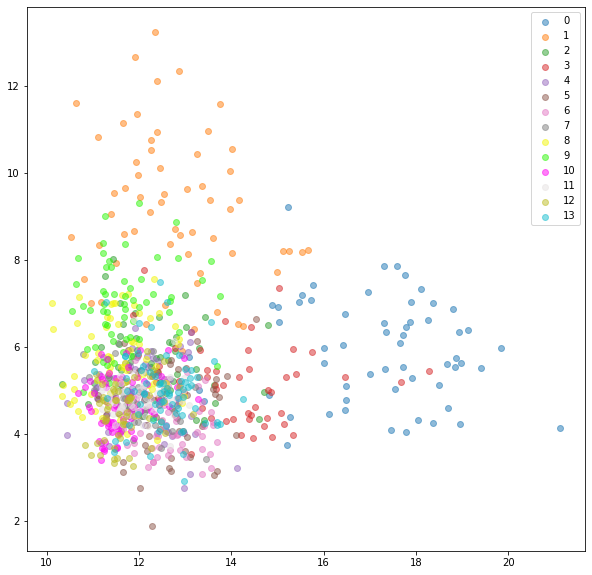

In [ ]:
d,l=extract_embeddings(test_loader,model)
plot_embeddings(d,l)

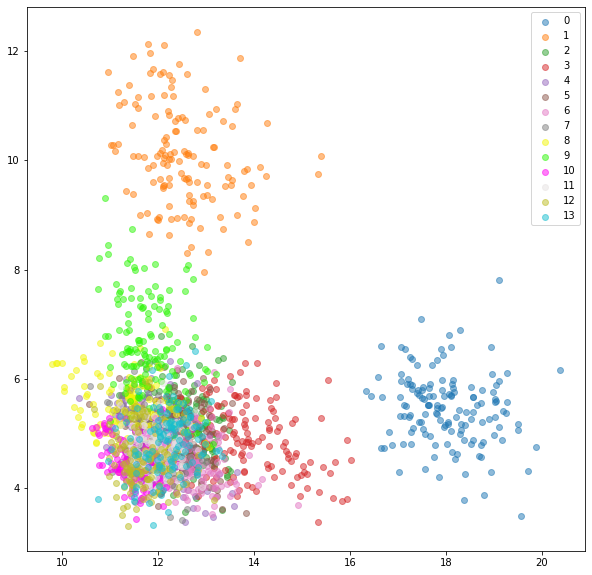

In [ ]:
d,l=extract_embeddings(train_loader,model)
plot_embeddings(d,l)

In [ ]:
d = torch.from_numpy(d)
l = torch.from_numpy(l)

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
id=torch.tensor([[i,j] for i in range(839) for j in range(i+1,840)]).T
dis_matrix[id[0],id[1]].size()

In [ ]:
c=dis_matrix[:58,58:]
c[c>1].size(0)/(c.size(0)*c.size(1))

In [ ]:
c=dis_matrix[:58,58:]
c[c<2].size(0)/(c.size(0)**2)

In [ ]:
c=l.sort()[0]
for i in range(14):
  print(len(c[c==i]),end=", ")

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]

In [ ]:
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
dis_matrix[:142,142:].mean(),dis_matrix[:142,:142].mean()

In [ ]:
dis_matrix.max(),(dis_matrix.triu(1)+1000*torch.ones(1960,1960).tril()).min()

####Plotting results

In [ ]:
L=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_fc+rep-13-06.pkl",'rb'))

In [ ]:
loss_train=L[0]
loss_test=L[1]
acc_train=L[2]
acc_test=L[3]

In [ ]:
import matplotlib.pyplot as plt
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'b')
plt.grid()
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.5,"min Loss Train : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_train.png', dpi=fig.dpi)

In [ ]:
min(loss_tr)

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te,'b')
plt.grid()
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.2,"min Test Loss : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_test.png', dpi=fig.dpi)

In [ ]:
min(loss_te)

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr,'b')
plt.grid()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,80,"Max Train Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_train.png', dpi=fig.dpi)

In [ ]:
max(acc_tr)

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te,"b")
plt.grid()
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,75,"Max Test Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_te)+0.47, acc_te.index(max(acc_te))+1,len(acc_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_test.png', dpi=fig.dpi)

In [ ]:
M=max(acc_te)
M,acc_te.index(M)

#TRIPLET LOSS NETWORK 15-06

##Utils

In [ ]:
def dis(x1,x2):
  return (x1-x2).pow(2).sum(-1).sqrt()

In [ ]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [ ]:
class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllPositivePairSelector(PairSelector):
    """
    Discards embeddings and generates all possible pairs given labels.
    If balance is True, negative pairs are a random sample to match the number of positive samples
    """
    def __init__(self, balance=True):
        super(AllPositivePairSelector, self).__init__()
        self.balance = balance

    def get_pairs(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]
        if self.balance:
            negative_pairs = negative_pairs[torch.randperm(len(negative_pairs))[:len(positive_pairs)]]

        return positive_pairs, negative_pairs


In [ ]:
class HardNegativePairSelector(PairSelector):
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
        super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs


In [ ]:
class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

In [ ]:
class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


In [ ]:
def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

In [ ]:
def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None

In [ ]:
def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

In [ ]:
class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

In [ ]:
def HardestNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=hardest_negative,cpu=cpu)


In [ ]:
def RandomNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=random_hard_negative,cpu=cpu)

In [ ]:
def SemihardNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=lambda x: semihard_negative(x, margin),cpu=cpu)

##Metric

In [ ]:
class Metric:
    def __init__(self):
        pass

    def __call__(self, outputs, target, loss):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

    def name(self):
        raise NotImplementedError

In [ ]:
class AccumulatedAccuracyMetric(Metric):
    """
    Works with classification model
    """

    def __init__(self):
        self.correct = 0
        self.total = 0

    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()

    def reset(self):
        self.correct = 0
        self.total = 0

    def value(self):
        return 100 * float(self.correct) / self.total

    def name(self):
        return 'Accuracy'

In [ ]:
class AverageNonzeroTripletsMetric(Metric):
    '''
    Counts average number of nonzero triplets found in minibatches
    '''

    def __init__(self):
        self.values = []

    def __call__(self, outputs, target, loss):
        self.values.append(loss[1])
        return self.value()

    def reset(self):
        self.values = []

    def value(self):
        return np.mean(self.values)

    def name(self):
        return 'Average nonzero triplets'

##Plot

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12','13']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#F2F607','#2DF607','#FF01F3','#E7E2E2','#bcbd22', '#17becf']
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
  plt.figure(figsize=(10,10))
  for i in range(14):
    inds = np.where(targets==i)[0]
    plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
  if xlim:
    plt.xlim(xlim[0], xlim[1])
  if ylim:
    plt.ylim(ylim[0], ylim[1])
  plt.legend(classes)

def extract_embeddings(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 14))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for x in dataloader:
      images=x['data']
      target=x['label']
      if cuda:
          images = images.cuda()
      embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
      labels[k:k+len(images)] = target.numpy()
      k += len(images)
    return embeddings, labels

##Loss Function

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(-1).sqrt() #.pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(-1).sqrt() #.pow(.5)
        losses = distance_positive + F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

##Dataset

In [ ]:
class Shreck(Dataset):

  def __init__(self, train=True,transform=None):

    self.transform = transform
    self.train = train
    if self.train:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['data_train']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_train-15-06.pth")['label'] 

    else:
      self.data=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['data_test']
      self.target=torch.load("/content/drive/MyDrive/SPDAgg output/ST_TS_test-15-06.pth")['label'] 

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data=torch.tensor(self.data[idx],requires_grad=False)
    label=self.target[idx].type(torch.LongTensor)
    sample={"data":data,"label":label}
    return sample

In [ ]:
class TripletShreck(Dataset):

  def __init__(self, Shreck):
    self.train=Shreck.train
    self.transform = Shreck.transform
    if self.train:
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices=[torch.where(self.target==i)[0] for i in range(14)]
      x=self.label_to_indices
      positives=[[x[m][i].item(),x[m][i+1].item(),m] for m in range(14) for i in range(-1,len(x[m])-1)]#+[[x[m][i].item(),x[m][i-10].item(),m] for m in range(14) for i in range(10,len(x[m])-1,10)]
      triplets = torch.tensor(positives)
      t=[]
      for m in range(14):
        c = triplets[:,2]
        r1=torch.full((len(torch.where(c==m)[0]),),m).tolist()
        r2=random.sample([i for j in range(int(len(r1)/13)+2) for i in set(range(14))-{m}],len(r1))
        r3=random.sample(torch.arange(len(x[m])).tolist()+
                         [random.randint(0,len(x[m])-1) for i in range(len(r1)-len(x[m]))],len(r1))
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      negatives = torch.tensor([[x[m][i],x[n][j],0] for m,n,i,j in t])
      triplets[:,2] = negatives[:,1]
      self.triplets = random.sample(triplets.tolist(),len(triplets))

    else:
      random_state = np.random.RandomState(29)
      self.data=Shreck.data
      self.target=Shreck.target
      self.label_to_indices={i:torch.where(self.target==i)[0] for i in range(14)}
      x=self.label_to_indices
      positives = [[i,random_state.choice(self.label_to_indices[self.target[i].item()]),self.target[i].item()]
                  for i in range(0, len(self.data))]
      triplets = torch.tensor(positives)
      t=[]
      for m in range(14):
        r1=torch.full((len(torch.where(triplets[:,2]==m)[0]),),m).tolist()
        r2=random.sample([i for j in range(int(len(r1)/13)+2) for i in set(range(14))-{m}],len(r1))
        r3=random.sample(torch.arange(len(x[m])).tolist()+
                         [random.randint(0,len(x[m])-1) for i in range(len(r1)-len(x[m]))],len(r1))
        r4=[random.randint(0,len(x[n])-1) for n in r2]
        t+=torch.tensor([r1,r2,r3,r4]).T.tolist()
      negatives = torch.LongTensor([[x[m][i],x[n][j],0] for m,n,i,j in t])
      triplets[:,2] = negatives[:,1]
      self.triplets = random.sample(triplets.tolist(),len(triplets))

  def __len__(self):
    return len(self.triplets)

  def __getitem__(self,idx):
    anchor = torch.tensor(self.data[int(self.triplets[idx][0])],requires_grad=False)
    positive = torch.tensor(self.data[int(self.triplets[idx][1])],requires_grad=False)
    negative = torch.tensor(self.data[int(self.triplets[idx][2])],requires_grad=False)
    return {'data':(anchor, positive, negative)}

##Dataloader

In [ ]:
transformed_dataset = Shreck(train=True)
train_loader = DataLoader(transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

transformed_dataset_val = Shreck(train=False)
test_loader = DataLoader(transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
triplet_transformed_dataset = TripletShreck(Shreck())
triplet_train_loader = DataLoader(triplet_transformed_dataset, batch_size=30,
                    shuffle=True, num_workers=2)

triplet_transformed_dataset_val = TripletShreck(Shreck(train=False))
triplet_test_loader = DataLoader(triplet_transformed_dataset_val, batch_size=30,
                    shuffle=False, num_workers=2)

In [ ]:
rep=torch.zeros(14,200,200)
for j in range(14):
  i=0
  while int(train_loader.dataset[i]['label'].item())!=j:
    i+=1
  rep[j]=train_loader.dataset[i]['data']

In [ ]:
tu=[train_loader.dataset[i]['data'].unsqueeze(0) for i in range(1960)]
tot=torch.cat(tuple(tu),0)
tu=[train_loader.dataset[i]['label'].unsqueeze(0) for i in range(1960)]
tot_label=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['data'].unsqueeze(0) for i in range(840)]
tot_test=torch.cat(tuple(tu),0)
tu=[test_loader.dataset[i]['label'].unsqueeze(0) for i in range(840)]
tot_label_test=torch.cat(tuple(tu),0)

##Training & Test

In [ ]:
def train(epoch,train_loader, model, loss_fn, optimizer, cuda,tot,tot_label,rep,m):
  model.train()
  total_loss = 0
  correct = 0.0
  total = 0.0
  bar = notebook.tqdm(enumerate(train_loader))
  for batch_idx, x in bar:
    data=x['data']
    if not type(data) in (tuple, list):
      data = (data,)
    optimizer.zero_grad()
    outputs = model(*data)

    #if type(outputs) not in (tuple, list):
     # outputs = (outputs,)
    """x1, x2, x3 = outputs
    pd= x1 -x2
    nd = x1 - x3
    pd = pd.pow(2).sum(-1)#.sqrt()
    nd = nd.pow(2).sum(-1)#.sqrt()
    loss = F.relu(pd -nd +m)
    loss = loss.mean()"""
    loss_inputs = outputs
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    total_loss += loss.item()
    total += x['data'][0].size(0)
    loss.backward()
    optimizer.step()
    bar.set_description('Loss: %.3f |(%d/%d)'% (total_loss/(batch_idx+1.0),0, total))
    if batch_idx==65:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
          % (total_loss/(batch_idx+1),100.*Acc/len(x), Acc,1960))
  return (total_loss/(batch_idx+1), 100.*Acc/len(x))

In [ ]:
def test(epoch,dataloader_val,model, loss_fn, cuda,tot,tot_label,rep,m):
  model.eval()
  test_loss = 0
  total = 0.0
  bar = notebook.tqdm(enumerate(dataloader_val))
  for batch_idx, x in bar:
    data=x['data']

    if not type(data) in (tuple, list):
      data = (data,)
    outputs = model(*data)

    if type(outputs) not in (tuple, list):
      outputs = (outputs,)

    loss_inputs = outputs
    loss_outputs = loss_fn(*loss_inputs)
    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
    test_loss += loss.data.item()
    total += x['data'][0].size(0)

    bar.set_description('Loss: %.3f | Acc: %.3f%% (%d/%d)'
      % (test_loss/(batch_idx+1), 0., 0, total))
    if batch_idx==27:
      x=model.get_embedding(tot)
      x_rep=model.get_embedding(rep)
      dist_matrix=dis(x.unsqueeze(1).expand(x.size(0),14,14),x_rep.unsqueeze(0).expand(x.size(0),14,14))
      d=dist_matrix.min(1)[1]-tot_label
      Acc=d[d==0].size(0)
      bar.set_description('Loss: %.3f|Acc : %.2f%% (%d/%d)'
                        % (test_loss/(batch_idx+1),100.*Acc/len(x), Acc,total))
  return (test_loss/(batch_idx+1), 100.*Acc/len(x))

##Model

###SPDNet

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.trans1 = SPDTransform(200, 150)
    self.trans2 = SPDTransform(150, 100)
    self.trans3 = SPDTransform(100, 50)
    self.rect1  = SPDRectified()
    self.rect2  = SPDRectified()
    self.rect3  = SPDRectified()
    self.tangent = SPDTangentSpace(50)
    self.linear = nn.Linear(1275, 14, bias=True)
    # self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.trans1(x)
    x = self.rect1(x)
    x = self.trans2(x)
    x = self.rect2(x)
    x = self.trans3(x)
    x = self.rect3(x)
    x = self.tangent(x)
    # x = self.dropout(x)
    x = self.linear(x.type(torch.FloatTensor))
    return x

  def get_embedding(self,x):
    return self.forward(x)

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [ ]:
margin = 2
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/TS+SPDNet-12-06.pth"))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+ts+spdnet13-06.pth"))

<All keys matched successfully>

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test={},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,siamese_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,siamese_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/siamese_ts_spdnet+rep-14-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+ts+spdnet14-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/siamese+ts+spdnet14-06.pth")


Epoch  1 :


KeyboardInterrupt: ignored

In [ ]:
d,l=extract_embeddings(train_loader,model)
plot_embeddings(d,l)

In [ ]:
#d = torch.from_numpy(d)
#l = torch.from_numpy(l)
d=d[l.sort()[1].type(torch.LongTensor)]
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
id=torch.tensor([[i,j] for i in range(839) for j in range(i+1,840)]).T
dis_matrix[id[0],id[1]].size()

In [ ]:
c=dis_matrix[:58,58:]
c[c>1].size(0)/(c.size(0)*c.size(1))

In [ ]:
c=dis_matrix[:58,58:]
c[c<2].size(0)/(c.size(0)**2)

In [ ]:
c=l.sort()[0]
for i in range(14):
  print(len(c[c==i]),end=", ")

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]

In [ ]:
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
dis_matrix[:142,142:].mean(),dis_matrix[:142,:142].mean()

In [ ]:
dis_matrix.max(),(dis_matrix.triu(1)+1000*torch.ones(1960,1960).tril()).min()

####Plotting results

In [ ]:
L=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_spdnet+rep-13-06.pkl", 'rb'))

In [ ]:
loss_train=L[0]
loss_test=L[1]
acc_train=L[2]
acc_test=L[3]

In [ ]:
import matplotlib.pyplot as plt
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'b')
plt.grid()
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.text(40,0.3,"min Loss Train : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_train.png', dpi=fig.dpi)

In [ ]:
min(loss_tr)

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te,'b')
plt.grid()
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.2,"min Test Loss : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_test.png', dpi=fig.dpi)

In [ ]:
min(loss_te)

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr,'b')
plt.grid()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,50,"Max Train Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_train.png', dpi=fig.dpi)

In [ ]:
max(acc_tr)

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te,"b")
plt.grid()
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,75,"Max Test Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_te)+0.47, acc_te.index(max(acc_te))+1,len(acc_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_test.png', dpi=fig.dpi)

In [ ]:
M=max(acc_te)
M,acc_te.index(M)

###FC

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.tangent = SPDTangentSpace(200)
    self.linear = nn.Linear(20100, 14, bias=True)
    # self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.tangent(x)
    # x = self.dropout(x)
    x = self.linear(x)
    return x

  def get_embedding(self,x):
    return self.forward(x)

In [ ]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

####margin=1

In [ ]:
margin = 1
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = TripletNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,triplet_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,triplet_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/triplet_st_ts_fc-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-15-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-15-06.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :


KeyboardInterrupt: ignored

####margin=7

In [ ]:
margin = 7
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = TripletNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,triplet_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,triplet_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/triplet_st_ts_fc-margin=7-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-margin=7-15-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-margin=7-15-06.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :




Epoch  11 :




Epoch  12 :




Epoch  13 :




Epoch  14 :




Epoch  15 :




Epoch  16 :




Epoch  17 :




Epoch  18 :




Epoch  19 :




Epoch  20 :




Epoch  21 :




Epoch  22 :




Epoch  23 :




Epoch  24 :




Epoch  25 :




Epoch  26 :




Epoch  27 :




Epoch  28 :




Epoch  29 :




Epoch  30 :




Epoch  31 :




Epoch  32 :




Epoch  33 :




Epoch  34 :




Epoch  35 :




Epoch  36 :




Epoch  37 :




Epoch  38 :




Epoch  39 :




Epoch  40 :




Epoch  41 :




Epoch  42 :




Epoch  43 :




Epoch  44 :




Epoch  45 :




Epoch  46 :




Epoch  47 :




Epoch  48 :




Epoch  49 :




Epoch  50 :




Epoch  51 :




Epoch  52 :




Epoch  53 :




Epoch  54 :




Epoch  55 :




Epoch  56 :




Epoch  57 :




Epoch  58 :




Epoch  59 :




Epoch  60 :




Epoch  61 :




Epoch  62 :




Epoch  63 :




Epoch  64 :




Epoch  65 :




Epoch  66 :




Epoch  67 :




Epoch  68 :




Epoch  69 :




Epoch  70 :




Epoch  71 :




Epoch  72 :




Epoch  73 :




Epoch  74 :




Epoch  75 :




Epoch  76 :




Epoch  77 :




Epoch  78 :




Epoch  79 :




Epoch  80 :




Epoch  81 :




Epoch  82 :




Epoch  83 :




Epoch  84 :




Epoch  85 :




Epoch  86 :




Epoch  87 :




Epoch  88 :




Epoch  89 :




Epoch  90 :




Epoch  91 :




Epoch  92 :




Epoch  93 :




Epoch  94 :




Epoch  95 :




Epoch  96 :




Epoch  97 :




Epoch  98 :




Epoch  99 :




Epoch  100 :




Epoch  101 :




Epoch  102 :




Epoch  103 :




Epoch  104 :




Epoch  105 :




Epoch  106 :




Epoch  107 :




Epoch  108 :




Epoch  109 :




Epoch  110 :




Epoch  111 :




Epoch  112 :




Epoch  113 :




Epoch  114 :




Epoch  115 :




Epoch  116 :




Epoch  117 :




Epoch  118 :




Epoch  119 :




Epoch  120 :




Epoch  121 :




Epoch  122 :




Epoch  123 :




Epoch  124 :




Epoch  125 :




Epoch  126 :




Epoch  127 :




Epoch  128 :




Epoch  129 :




Epoch  130 :




Epoch  131 :




Epoch  132 :




Epoch  133 :




Epoch  134 :




Epoch  135 :




Epoch  136 :




Epoch  137 :




Epoch  138 :




Epoch  139 :




Epoch  140 :




Epoch  141 :




Epoch  142 :




Epoch  143 :




Epoch  144 :




Epoch  145 :




Epoch  146 :




Epoch  147 :




Epoch  148 :




Epoch  149 :




Epoch  150 :




Epoch  151 :




Epoch  152 :




Epoch  153 :




Epoch  154 :




Epoch  155 :




Epoch  156 :




Epoch  157 :




Epoch  158 :




Epoch  159 :




Epoch  160 :




Epoch  161 :




Epoch  162 :




Epoch  163 :




Epoch  164 :




Epoch  165 :




Epoch  166 :




Epoch  167 :




Epoch  168 :




Epoch  169 :




Epoch  170 :


KeyboardInterrupt: ignored

####margin=10

In [ ]:
margin = 10
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = TripletNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,triplet_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,triplet_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/triplet_st_ts_fc-margin=10-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-margin=10-15-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-margin=10-15-06.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :




Epoch  4 :




Epoch  5 :




Epoch  6 :




Epoch  7 :




Epoch  8 :




Epoch  9 :




Epoch  10 :


KeyboardInterrupt: ignored

####margin=40

In [ ]:
margin = 1000
embedding_net = Net()
embedding_net.load_state_dict(torch.load("/content/drive/MyDrive/models/ST-TS+FC-15-06.pth"))
model = TripletNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [ ]:
start_epoch = 1
loss_train,loss_test,acc_train,acc_test = {},{},{},{}
for epoch in range(start_epoch, start_epoch+500):
  print("\nEpoch ",epoch,":")
  train_loss, train_acc = train(epoch,triplet_train_loader, model, loss_fn, optimizer, cuda,tot,tot_label, rep,margin)
  test_loss, test_acc  = test(epoch,triplet_test_loader, model, loss_fn, cuda,tot_test,tot_label_test, rep,margin)
  loss_train[epoch],loss_test[epoch],acc_train[epoch],acc_test[epoch]=train_loss,test_loss,train_acc,test_acc
  L=[loss_train,loss_test,acc_train,acc_test]
  with open("/content/drive/MyDrive/results/results/triplet_st_ts_fc-margin=1000-15-06.pkl", 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(L, f)
  if test_acc>=max(acc_test.values()):
    torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-margin=1000-15-06_best.pth")
  torch.save(model.state_dict(),"/content/drive/MyDrive/models/triplet+st+ts+fc-margin=1000-15-06.pth")


Epoch  1 :




Epoch  2 :




Epoch  3 :


KeyboardInterrupt: ignored

####Dispersion

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/siamese+st+ts+fc-margin=10-15-06_best.pth"))

<All keys matched successfully>

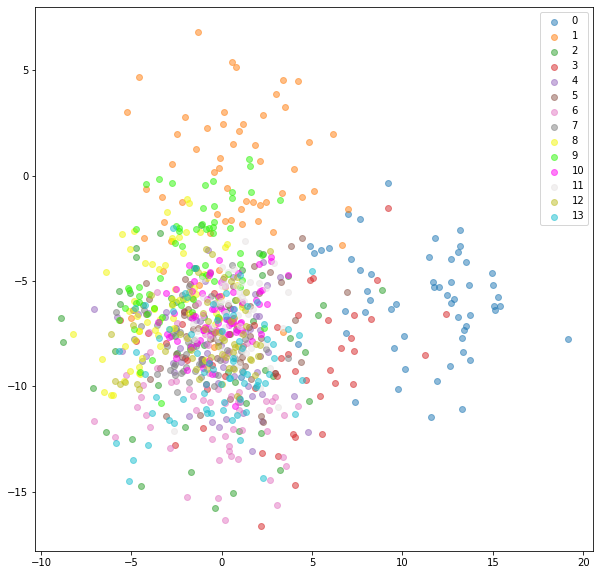

In [ ]:
d,l=extract_embeddings(test_loader,model)
plot_embeddings(d,l)

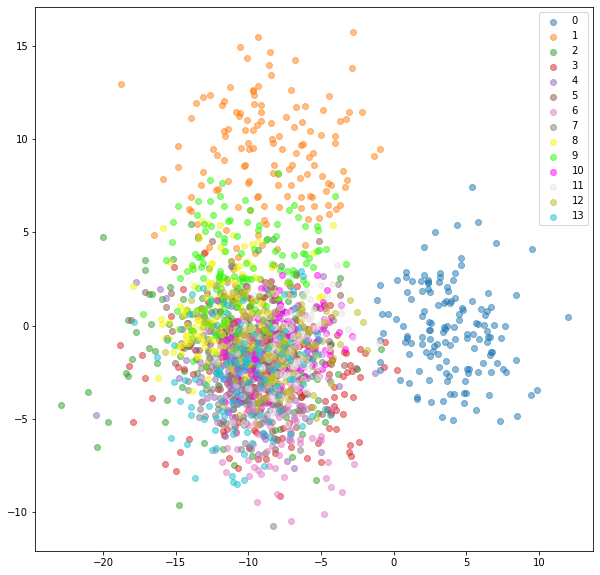

In [ ]:
d,l=extract_embeddings(train_loader,model)
plot_embeddings(d,l)

In [ ]:
d = torch.from_numpy(d)
l = torch.from_numpy(l)

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

tensor([[ 0.0000, 10.9642,  8.9478,  ..., 28.8665, 30.7012, 29.0617],
        [10.9642,  0.0000, 15.8888,  ..., 26.0639, 29.3837, 30.0492],
        [ 8.9478, 15.8888,  0.0000,  ..., 30.9560, 30.8612, 27.9412],
        ...,
        [28.8665, 26.0639, 30.9560,  ...,  0.0000, 10.9431, 18.1791],
        [30.7012, 29.3837, 30.8612,  ..., 10.9431,  0.0000, 12.7060],
        [29.0617, 30.0492, 27.9412,  ..., 18.1791, 12.7060,  0.0000]], dtype=torch.float64)

In [ ]:
r=dis_matrix[dis_matrix!=0]
r.min()

tensor(2.4816, dtype=torch.float64)

In [ ]:
eid=torch.tensor([[i,j] for i in range(839) for j in range(i+1,840)]).T
dis_matrix[id[0],id[1]].size()

In [ ]:
c=dis_matrix[:58,58:]
c[c>1].size(0)/(c.size(0)*c.size(1))

In [ ]:
c=dis_matrix[:58,58:]
c[c<2].size(0)/(c.size(0)**2)

In [ ]:
c=l.sort()[0]
for i in range(14):
  print(len(c[c==i]),end=", ")

In [ ]:
d=d[l.sort()[1].type(torch.LongTensor)]

In [ ]:
dis_matrix = dis(d.expand(1960,1960,14), d.unsqueeze(1).expand(1960,1960,14))
dis_matrix

In [ ]:
dis_matrix[:142,142:].mean(),dis_matrix[:142,:142].mean()

In [ ]:
dis_matrix.max(),(dis_matrix.triu(1)+1000*torch.ones(1960,1960).tril()).min()

####Plotting results

In [ ]:
L=pickle.load(open("/content/drive/MyDrive/results/results/siamese_ts_fc+rep-13-06.pkl",'rb'))

In [ ]:
loss_train=L[0]
loss_test=L[1]
acc_train=L[2]
acc_test=L[3]

In [ ]:
import matplotlib.pyplot as plt
epochs,loss_tr=list(loss_train.keys()),list(loss_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_tr,'b')
plt.grid()
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.5,"min Loss Train : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_tr), loss_tr.index(min(loss_tr))+1,len(loss_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_train.png', dpi=fig.dpi)

In [ ]:
min(loss_tr)

In [ ]:
epochs,loss_te=list(loss_test.keys()),list(loss_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,loss_te,'b')
plt.grid()
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,1.2,"min Test Loss : %.3f \n\nat the epoch n°: %d/%d \n"
        %(min(loss_te), loss_te.index(min(loss_te))+1,len(loss_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_loss_test.png', dpi=fig.dpi)

In [ ]:
min(loss_te)

In [ ]:
epochs,acc_tr=list(acc_train.keys()),list(acc_train.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_tr,'b')
plt.grid()
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,80,"Max Train Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_tr), acc_tr.index(max(acc_tr))+1,len(acc_tr)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_train.png', dpi=fig.dpi)

In [ ]:
max(acc_tr)

In [ ]:
epochs,acc_te=list(acc_test.keys()),list(acc_test.values())
fig=plt.figure(figsize=(10,7))
plt.plot(epochs,acc_te,"b")
plt.grid()
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.text(40,75,"Max Test Accuracy : %.2f%% \n\nat the epoch n°: %d/%d \n"
        %(max(acc_te)+0.47, acc_te.index(max(acc_te))+1,len(acc_te)),
         fontsize='x-large',c='g',backgroundcolor="w")
fig.savefig('siamese_acc_test.png', dpi=fig.dpi)

In [ ]:
M=max(acc_te)
M,acc_te.index(M)